# 11. 어제 오른 내 주식, 과연 내일은?

## 11-9. 프로젝트 : 주식 예측에 도전해 보자

---

### 목차
- STEP 1 : 시계열 데이터 준비
- STEP 2 : 각종 전처리 수행
- STEP 3 : 시계열 안정성 분석
- STEP 4 : 학습, 테스트 데이터셋 생성
- STEP 5 : 적정 ARIMA 모수 찾기
- STEP 6 : ARIMA 모델 훈련과 테스트
- STEP 7 : 다른 주식 종목 예측해 보기

---

### STEP 1 : 시계열 데이터 준비
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
- 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

- 데이터셋은 [Yahoo Finance](https://finance.yahoo.com/) 에서 다운로드할 수 있습니다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/E-16-5.max-800x600.png)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

print('슝=3')

슝=3


#### 1. 시계열(Time Series) 생성
- 시계열(Time Series): 시간 컬럼('Date')을 index로 하는 Series
    - type(df): DataFrame
    - type(df['Close']): Series

In [2]:
# Time Series 생성
dataset_filepath = 'stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

ts = df['Close']  # 시계열 데이터: 종가(Close)
ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

- 시계열 데이터 시각화

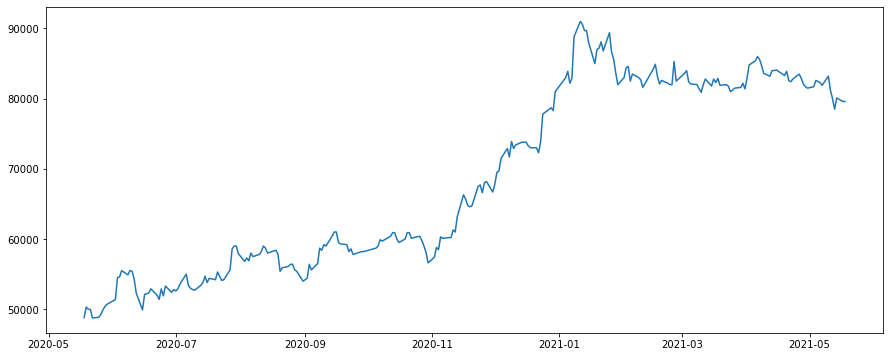

In [3]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

### STEP 2 : 각종 전처리 수행
- 결측치 처리
- 로그 변환

#### 1. 결측치 처리
cf. 결측치 NaN 은 통계분석 시 오류 발생시킴, 분석 결과에 악영향 => 처리해야 함!
- 결측치 처리 방법 2가지
    - 결측치 데이터 모두 삭제(drop)
    - 결측치 양옆 값을 이용해서 보간(interpolate)하여 대입 [[참고]](https://rfriend.tistory.com/264)
        - (1) 시계열데이터의 값에 선형으로 비례하는 방식으로 결측값 보간(interpolate TimeSeries missing values linearly)
        - (2) 시계열 날짜 index를 기준으로 결측값 보간(interploate TimeSeries missing values along with Time-index)
        - (3) DataFrame 값에 선형으로 비례하는 방식으로 결측값 보간(interpolate DataFrame missing values linearly)
        - (4) 결측값 보간 개수 제한하기(limit the number of consecutive interpolation)
- 선택한 방식
    - 시간을 index로 가지는 시계열 데이터이므로 삭제(drop)보다 보간(interpolate)해야 한다.
    - 보간하는 방법 중 2번째 방식을 사용하겠다. time 을 기준으로 결측치를 보간한다.

In [4]:
ts[ts.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [5]:
# 결측치 처리

# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts = ts.interpolate(method='time')

ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

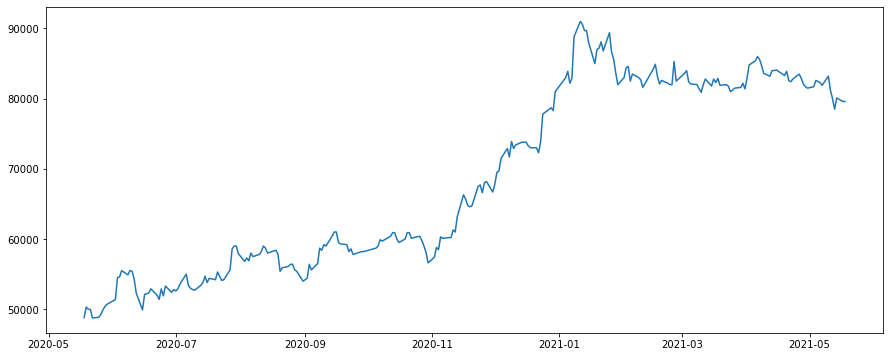

In [6]:
# 다시 그래프를 확인해봅시다!
plt.plot(ts)

다행히 데이터에 결측치가 존재하지 않았다. 그래서 결측치를 처리하는 보간(interpolate) 방법이 적용되지 않아서 그래프에 변화가 생기지 않았다.

#### 2. 로그 변환
- 변동폭이 일정하지 않을 경우, 로그 변환을 통해 시간의 흐름에 따라 분산이 일정하게 유지되는 정상 시계열로 변환

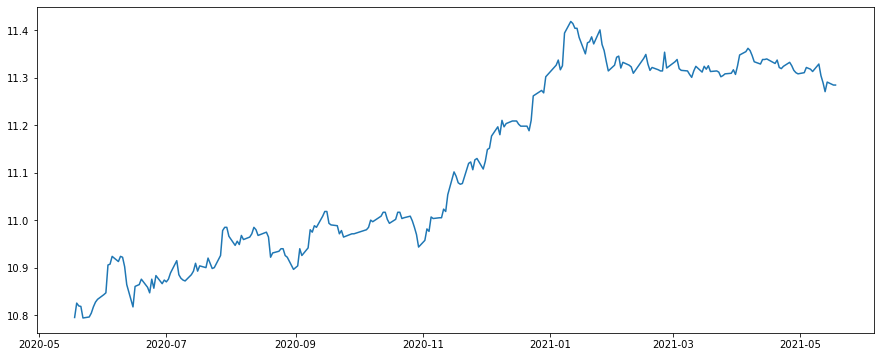

In [7]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

### STEP 3 : 시계열 안정성(Stationarity) 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

#### 1. 정성적 그래프 분석: 구간 통계치(Rolling Statistics) 시각화

`현재 타임 스텝` 부터 `window에 주어진 타임 스텝 이전` 사이 원본 시계열, 구간의 평균(rolling mean, `이동평균`), 표준편차(rolling std, `이동표준편차`) 시각화
- 원본 시계열
- 이동평균(MA, Moving Average) [[참고]](https://www.econowide.com/3544)
    - 일정 데이터 구간의 평균의 흐름을 알 수 있음
    - 이동평균 종류: 단순 이동평균(Simple MA), 가중 이동평균, 누적 이동평균, 지수 이동평균 등
- 이동표준편차

In [8]:
# 정성적 그래프 분석: 구간 통계치(Rolling Statistics) 시각화
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    plt.figure(figsize=(15,6))
    ax_1 = plt.subplot(111)
    ax_2 = ax_1.twinx()
    orig, = ax_1.plot(timeseries, color='blue',label='Original')  # 원본 시계열     
    mean, = ax_1.plot(rolmean, color='red', label='Rolling Mean')  # 구간의 평균(rolling mean, 이동평균)
    std, = ax_2.plot(rolstd, color='green', label='Rolling Std')  # 표준편차(rolling std, 이동표준편차)
    label = [orig, mean]
    ax_1.legend(label, [i.get_label() for i in label], loc=2)
    ax_2.legend()
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

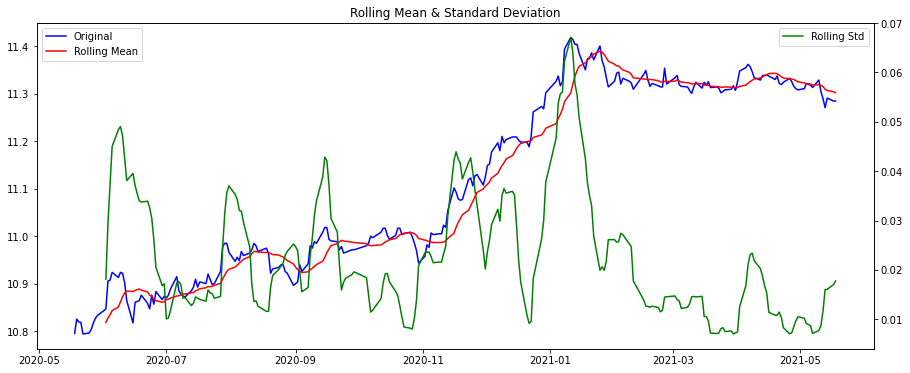

In [9]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

- 정성적 결론
    - 시간의 추이에 따라 평균과 분산이 증가하는 패턴 => 이 시계열 데이터는 안정적이지 않음(Non-Stationary)

#### 2. 정량적 Augmented Dicky-Fuller Test
- ADF Test(Augmented Dickey-Fuller Test)
    - 시계열 데이터 안정성(stationary)을 테스트하는 통계적 방법
    - statsmodels 패키지의 adfuller 메소드 사용
        - statsmodels 패키지: R 에서 제공하는 통계검정, 시계열분석 등의 기능을 파이썬에서 이용할 수 있는 강력한 통계 패키지
        - adfuller(): 주어진 time series 에 대한 ADF Test 수행
    - 정상성(stationary)를 알아보기 위한 단위근 검정 방법
        - 단위근(unit root): x=1, y=1 인 해, 시계열 자료에서 예측할 수 없는 결과를 가져옴
        - 귀무가설: 단위근이 존재한다. => 시계열 자료가 정상적이지 않다.
        - 대립가설: 단위근이 존재하지 않는다. => 시계열 자료가 정상성을 만족한다.
    - ADF 검정 = DF 검정 + p lag의 차분(differencing)
        - Dickey-Fuller 단위근 검정의 귀무가설: 단위근이 존재한다.
    - 정상적(stationary)인 시계열 데이터가 되려면?
        - 검정통계량 < Critical value
        - p-value < 유의수준 값
- ADF Test 내용
> 1. `주어진 시계열 데이터가 안정적이지 않다`라는 `귀무가설(Null Hypothesis)`를 세운 후,
> 2. 통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우에
> 3. `이 시계열 데이터가 안정적이다`라는 `대립가설(Alternative Hypothesis)`을 **채택** 한다
- 용어 정리
    - 귀무가설(Null Hypothesis)
        - 통계학에서 처음부터 버릴 것을 예상하는 가설
        - 통계학적 증거를 통해 증명하려는 가설
        - e.g. 전국 남학생의 평균 키는 170cm 와 같다.(=차이가 없다.)
    - 대립가설(Alternative Hypothesis)
        - 귀무가설이 거짓이라면(=기각된다면) 대안적으로 참(=채택)이 되는 가설
        - e.g. 전국 남학생의 평균 키는 170cm 와 다르다.(=차이가 있다.)
    - p-value
        - 귀무가설이 참이라고 가정했을 때, 표본으로 얻어지는 통계치(e.g. 표본 평균)이 나타날 확률
        - p-value 가 1에 가까움 => 귀무가설을 기각X (nonstationary)
        - p-value 가 0에 가까움(0.05 미만) => 귀무가설 기각 => 대립가설 채택 (stationary)

In [10]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


In [11]:
# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


- 정량적 결론
    - p-value 가 1에 가까움 => 귀무가설 기각X => nonstationary

#### 3. 시계열 분해(Time Series Decomposition)
- cf. nonstationary -> stationary 변환 방법
>1. 정성적인 분석을 통해 보다 안정적(stationary)인 특성을 가지도록 **기존의 시계열 데이터를 가공/변형** 하는 시도
>2. **시계열 분해(Time series decomposition)** 기법을 적용

2번째 방법으로 진행한다.

- **시계열 분해(Time Series Decomposition)**
    - Moving average 제거 - 추세(Trend) 상쇄하기
        - 추세 제거 방법: ts_log - MA(rolling mean)
            - MA 계산 시 windows size=12 일 경우, 앞 11개 데이터는 MA 계산이 안 됨 => 결측치(NaN) 발생 => 데이터셋에서 제거(.dropna())
            - 월 단위 발생 시계열 => windows size=12
    - 차분(Differencing) - 계절성(Seasonality) 상쇄하기
        - 계절성(Seasonality)
            - Trand 에는 잡히지 않는 패턴이 파악되지 않은 계절적/주기적 변화
            - MA 제거로 상쇄되지 않음
        - 차분(Differencing)
            - 차분 = 원래 시계열 - 한 스텝 앞으로 시프트한 시계열
            - 1차 차분 = 현재 스텝 값 - 직전 스텝 값 => 이번 스텝에서 발생한 변화량
            - 데이터에 따라서 2차 차분(2nd order differencing), 3차 차분(3rd order differencing)을 적용하면 p-value 를 더 낮출 수 있다.

    - statsmodels 라이브러리 속 seasonal_deompose 메소드
        - 시계열 안에 존재하는 trend, seasonality를 직접 분리할 수 있다. => 직접 수행한 MA 제거, differencing 거칠 필요 없이 훨씬 안정적인 시계열을 분리해낼 수 있다.

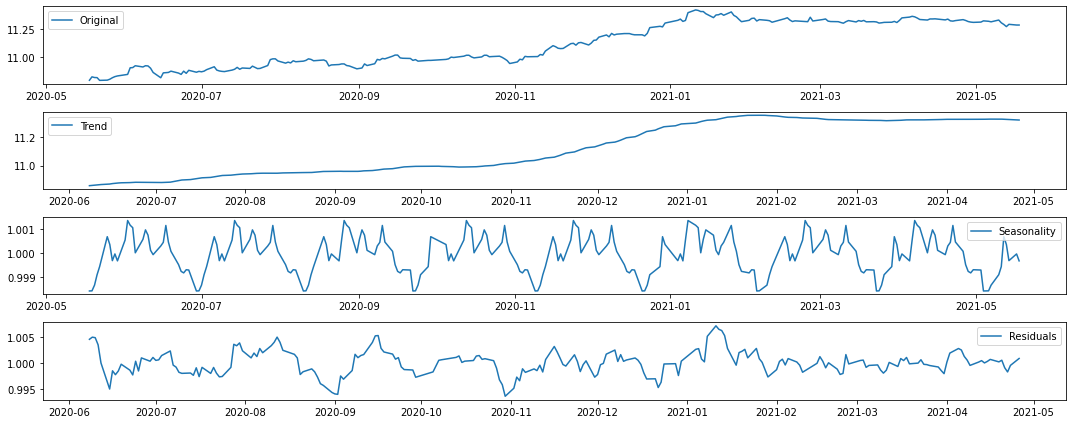

In [12]:
# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.figure(figsize=(15,6))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

#### 4. Residual 안정성 확인
- Residual = Original - Trend - Seasonality
- => Trend + Seasonality + Residual = Original

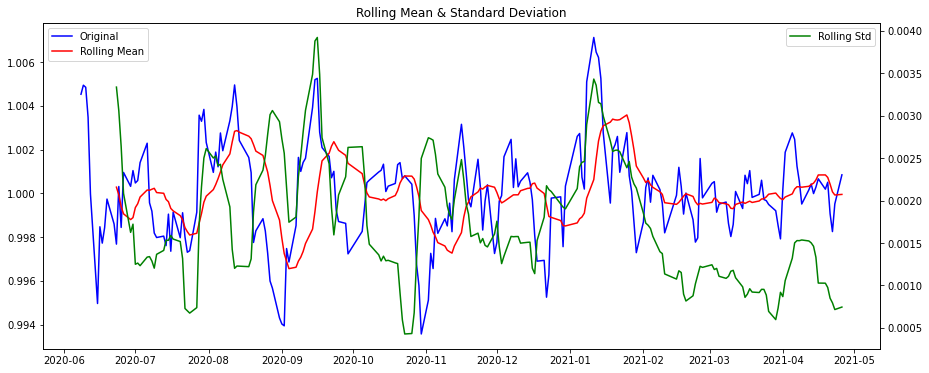

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


In [13]:
# Residual 안정성 확인
residual.dropna(inplace=True)
plot_rolling_statistics(residual)  # 정성적 그래프 분석
augmented_dickey_fuller_test(residual)  # 정량적 그래프 분석

### STEP 4 : 학습, 테스트 데이터셋 생성
- 학습, 테스트 데이터셋 9:1 비율로 분리
- 시계열 데이터이므로 가장 나중의 데이터를 테스트용으로 사용

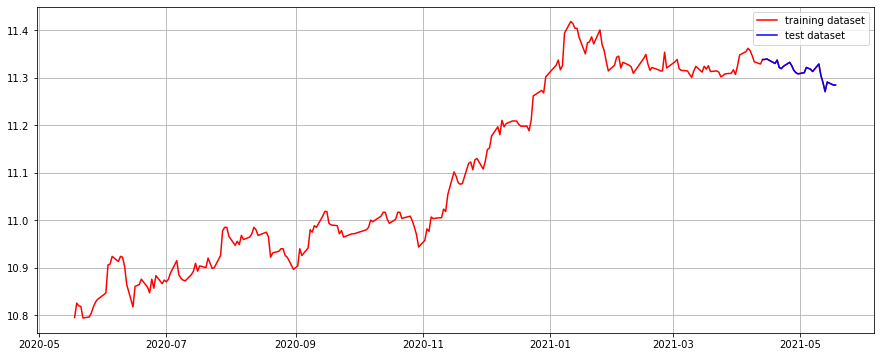

In [14]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(15,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### STEP 5 : 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

#### 1. ACF, PACF 그려보기 -> p,q 구하기

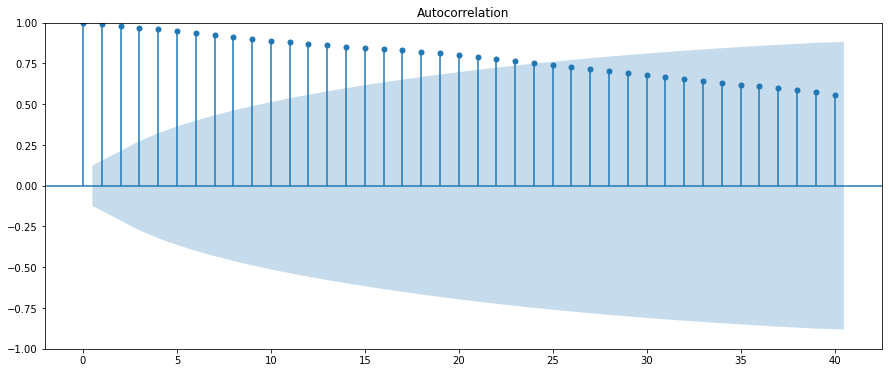

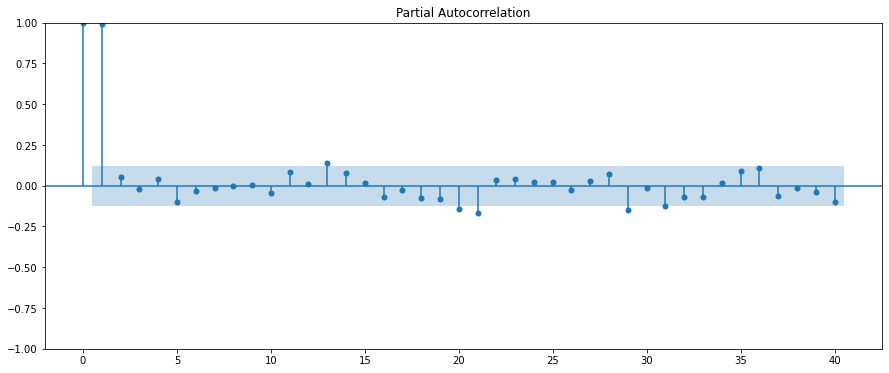

In [15]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log, lags=40)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log, lags=40)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- p,q 구하기
    - ACF(q): 값이 천천히 감소함(Damped exponential dying down))
    - PACF(p): lag 1 에서 값이 급격하게 하락함(Cut off lag 1)
- p,q 구하기 결론: AR(1) 또는 ARIMA(1,0,q)

#### 2. 차분 안정성 확인 -> d 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


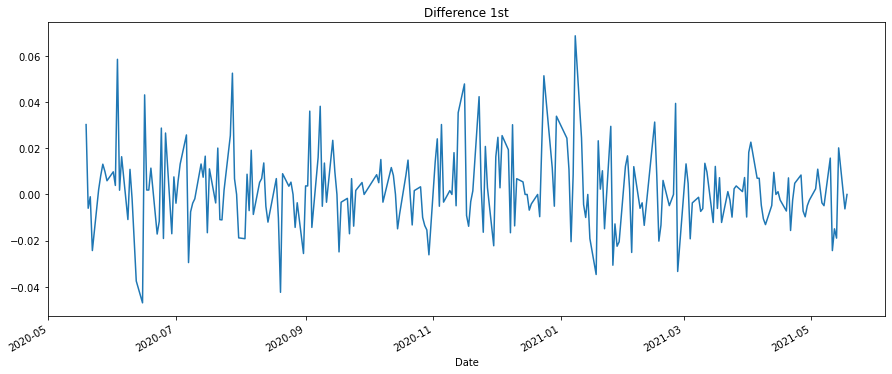

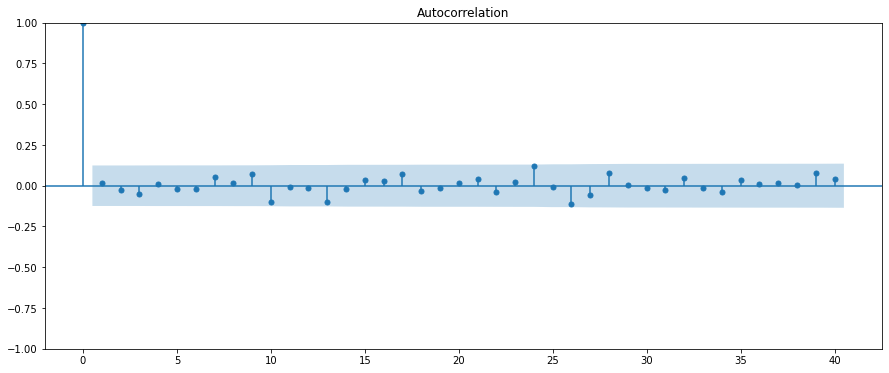

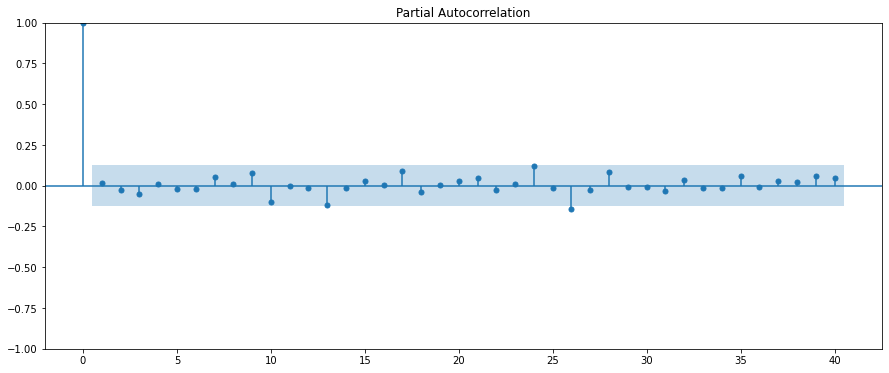

In [16]:
# 차분 안정성 확인 -> d 구하기

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 1차 차분 ACF, PACF 그려보기
plot_acf(diff_1, lags=40)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_1, lags=40)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


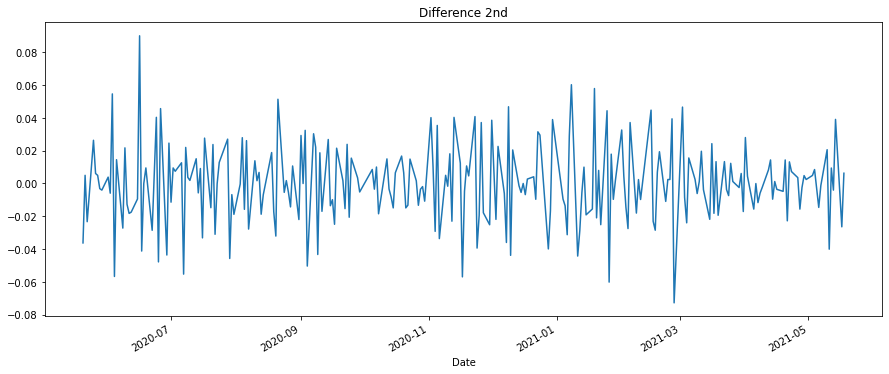

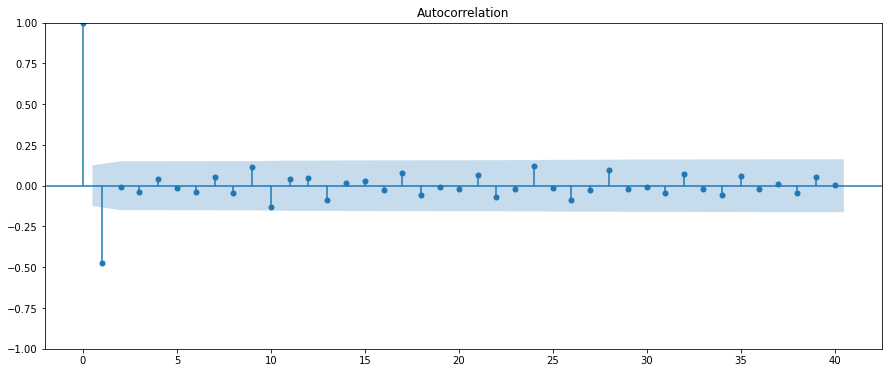

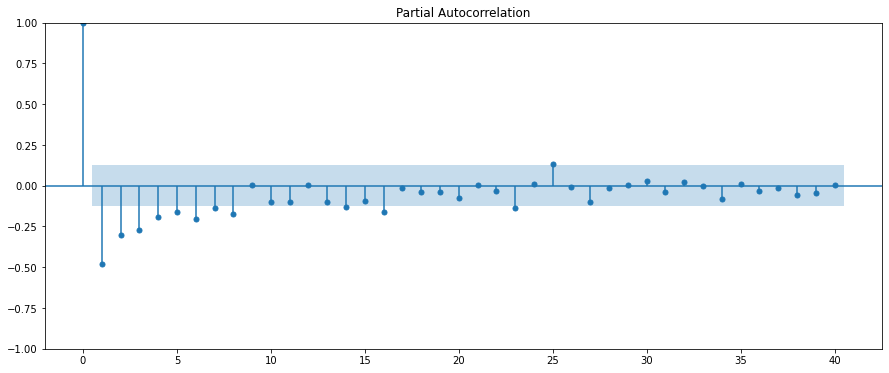

In [17]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# 2차 차분 ACF, PACF 그려보기
plot_acf(diff_2, lags=40)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_2, lags=40)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- d 구하기
    - d=0: 이미 앞서 stationary 변환을 했기 때문에 differencing 이 필요없음
    - d=1: ACF, PACF 모두 특정한 패턴이 보이지 않음, boundary 안에 값이 분포 => stationary 하다.
    - d=2: ACF, PACF 모두 특정한 패턴이 보이지 않음, PACF 를 보면 boundary 넘어서는 값이 꽤 있지만 실험 진행해보겠음
- d 구하기 결론: d=0, d=1, d=2 => ARIMA(1,0,q), ARIMA(1,1,q), ARIMA(1,2,q)

#### 3. 실험할 ARIMA 모델 파라미터 결정
|p|d|q|
|:---:|:---:|:---:|
|1|0|1|
|1|0|2|
|1|0|3|
|1|1|1|
|1|1|2|
|1|1|3|
|1|2|1|
|1|2|2|
|1|2|3|

- p=1 고정
- d=0,1,2 사용
- q=1,2,3 로 실험

### STEP 6 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

#### 1. ARIMA(1,0,1)

- ARIMA 모델 빌드와 훈련

In [18]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 0, 1)) # 모수 (p,d,q)
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 583.370
Date:                Fri, 18 Feb 2022   AIC                          -1158.741
Time:                        09:11:39   BIC                          -1145.076
Sample:                             0   HQIC                         -1153.226
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.127     87.360      0.000      10.841      11.338
ar.L1          0.9942      0.006    157.934      0.000       0.982       1.007
ma.L1          0.0392      0.063      0.623      0.5

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


- ARIMA 모델 훈련 결과 시각화

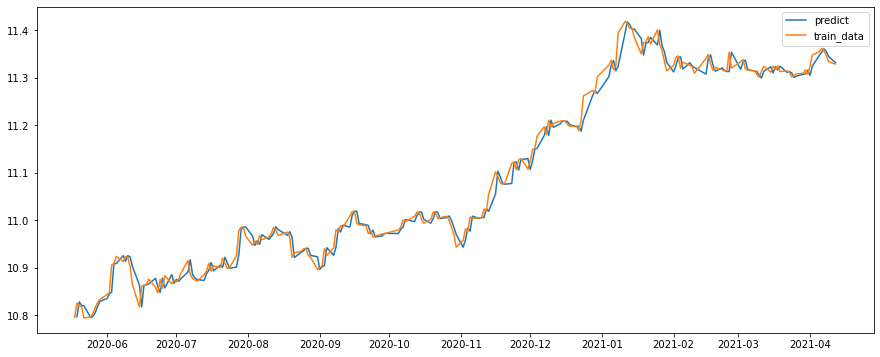

In [19]:
fitted_m_predict = fitted_m.predict()
fitted_m_predict = fitted_m_predict.drop(fitted_m_predict.index[0])
plt.figure(figsize=(15,6))
plt.plot(fitted_m_predict, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

- 모델 테스트 및 플로팅
    - forecast() 메소드 사용해서 테스트 데이터 구간의 데이터 예측

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


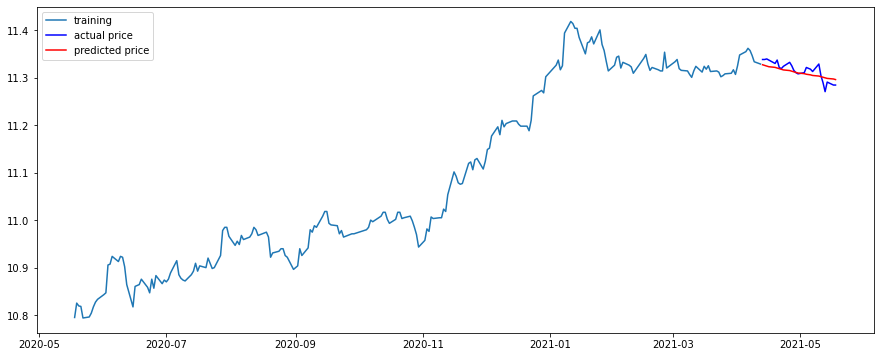

In [20]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(15,6))
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

- 최종 예측 모델 정확도 측정(MAPE)
    - np.exp() 사용하는 이유
        - 시계열 데이터를 로그 변환해서 사용했기 때문에 원본 스케일로 복구(=지수 변환)해야 정확한 오차를 계산할 수 있다.
    - MAPE = mean(abs(예측값 - 실제값))

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1057119.8161340607
MAE:  850.8270312480873
RMSE:  1028.1633217218268
MAPE: 1.04%


#### cf. 다른 모수로 ARIMA 모델 성능 측정하기 위해 코드 합침

In [22]:
def show_result_of_ARIMA_model(p,d,q):
    # 1. ARIMA 모델 빌드와 훈련
    # Build and Train  Model
    model = ARIMA(train_data, order=(p,d,q)) # 모수 (p,d,q)
    fitted_m = model.fit() 

    print(fitted_m.summary())


    # 2. ARIMA 모델 훈련 결과 시각화
    fitted_m_predict = fitted_m.predict()
    fitted_m_predict = fitted_m_predict.drop(fitted_m_predict.index[0])
    plt.figure(figsize=(15,6))
    plt.plot(fitted_m_predict, label='predict')
    plt.plot(train_data, label='train_data')
    plt.legend()


    # 3. 모델 테스트 및 플로팅
    # Forecast : 결과가 fc에 담깁니다. 
    fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
    fc = np.array(fc)

    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

    # Plot
    plt.figure(figsize=(15,6))
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.legend()
    plt.show()


    # 4. 예측 모델 정확도 측정
    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape*100))

#### 2. ARIMA(1,0,2)

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 0, 2)   Log Likelihood                 583.245
Date:                Fri, 18 Feb 2022   AIC                          -1156.491
Time:                        09:11:40   BIC                          -1139.410
Sample:                             0   HQIC                         -1149.597
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0712      0.109    101.368      0.000      10.857      11.285
ar.L1          0.9933      0.006    157.090      0.000       0.981       1.006
ma.L1          0.0460      0.063      0.728      0.4

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


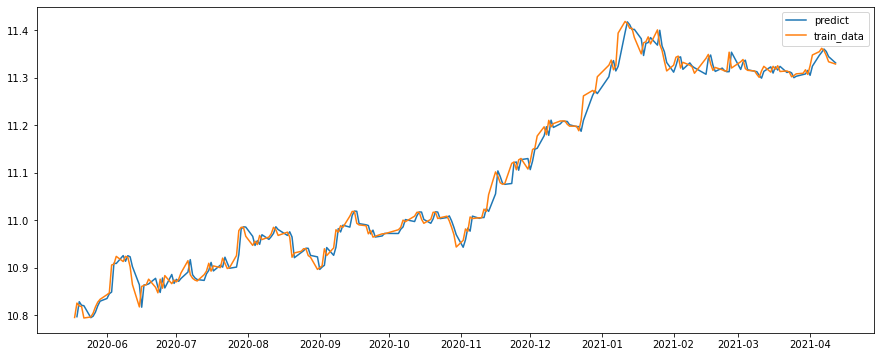

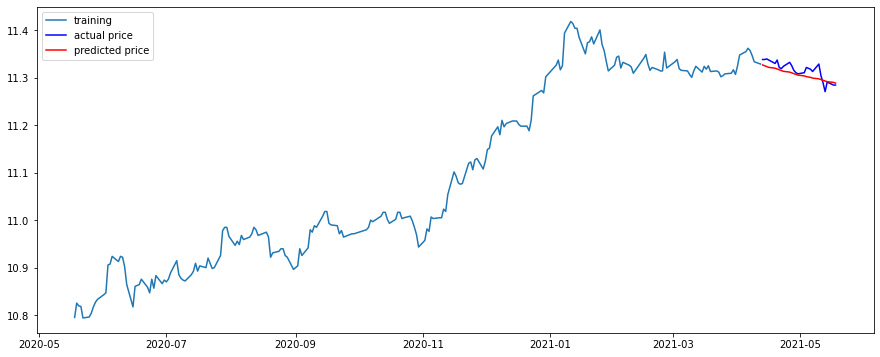

MSE:  1248422.4264901176
MAE:  943.3220446365298
RMSE:  1117.3282536882873
MAPE: 1.14%


In [23]:
show_result_of_ARIMA_model(1,0,2)

#### 3. ARIMA(1,0,3)

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 0, 3)   Log Likelihood                 583.725
Date:                Fri, 18 Feb 2022   AIC                          -1155.451
Time:                        09:11:41   BIC                          -1134.954
Sample:                             0   HQIC                         -1147.178
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0689      0.194     56.951      0.000      10.688      11.450
ar.L1          0.9971      0.006    159.125      0.000       0.985       1.009
ma.L1          0.0382      0.063      0.604      0.5

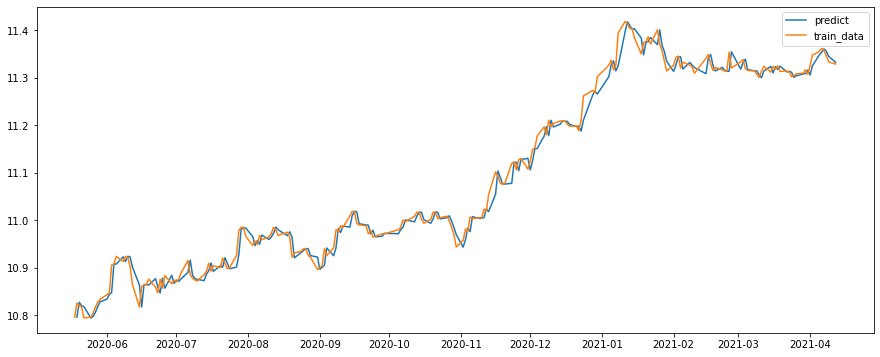

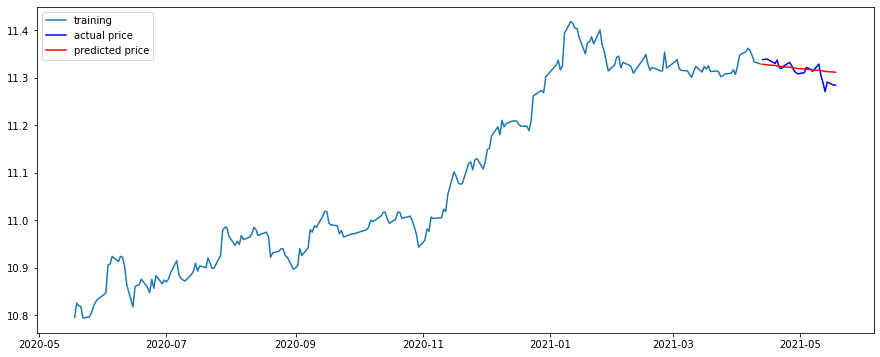

MSE:  1520583.9626439274
MAE:  949.9078552299121
RMSE:  1233.119605976617
MAPE: 1.17%


In [24]:
show_result_of_ARIMA_model(1,0,3)

#### 4. ARIMA(1,1,1)

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 583.489
Date:                Fri, 18 Feb 2022   AIC                          -1160.979
Time:                        09:11:42   BIC                          -1150.744
Sample:                             0   HQIC                         -1156.847
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0126      2.094      0.006      0.995      -4.092       4.117
ma.L1          0.0237      2.102      0.011      0.991      -4.096       4.143
sigma2         0.0003   2.47e-05     12.936      0.0

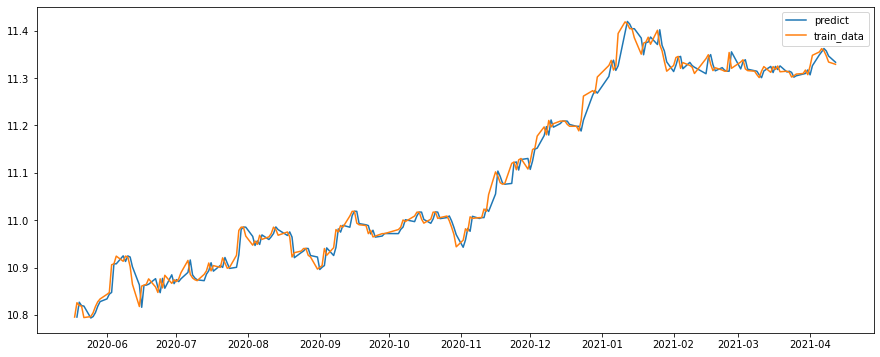

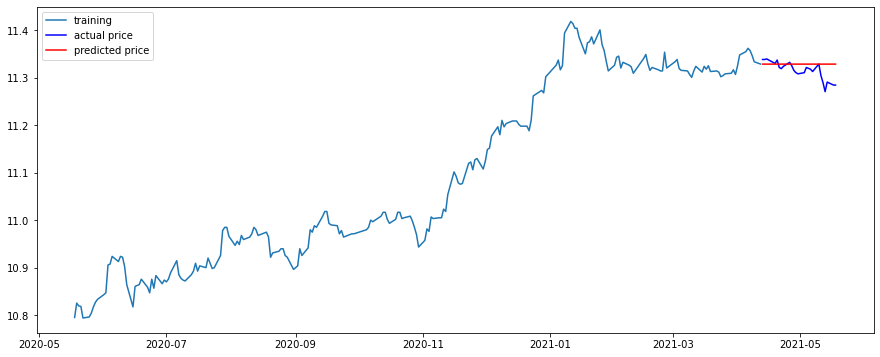

MSE:  3480580.4919100646
MAE:  1403.0537829615164
RMSE:  1865.6313922932538
MAPE: 1.74%


In [25]:
show_result_of_ARIMA_model(1,1,1)

#### 5. ARIMA(1,1,2)

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 583.492
Date:                Fri, 18 Feb 2022   AIC                          -1158.983
Time:                        09:11:42   BIC                          -1145.337
Sample:                             0   HQIC                         -1153.475
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2881     18.680     -0.015      0.988     -36.900      36.324
ma.L1          0.3224     18.689      0.017      0.986     -36.307      36.952
ma.L2          0.0134      0.630      0.021      0.9

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at 

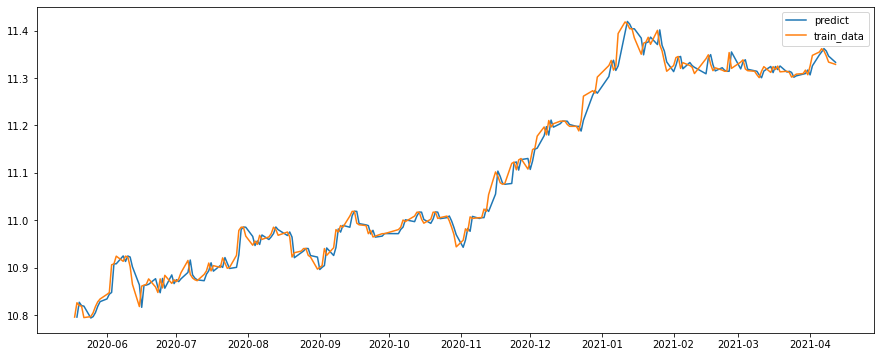

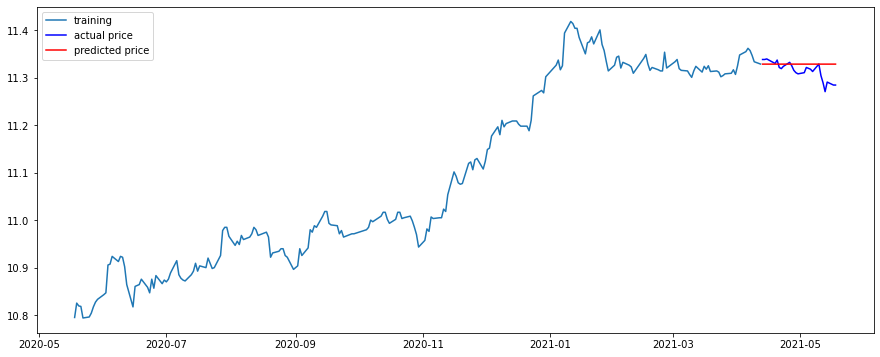

MSE:  3476519.3589361273
MAE:  1402.3552786871826
RMSE:  1864.5426675021752
MAPE: 1.73%


In [26]:
show_result_of_ARIMA_model(1,1,2)

#### 6. ARIMA(1,1,3)

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 3)   Log Likelihood                 583.408
Date:                Fri, 18 Feb 2022   AIC                          -1156.816
Time:                        09:11:43   BIC                          -1139.758
Sample:                             0   HQIC                         -1149.930
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7649      0.859     -0.891      0.373      -2.448       0.918
ma.L1          0.7984      0.862      0.927      0.354      -0.890       2.487
ma.L2          0.0185      0.091      0.204      0.8

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at 

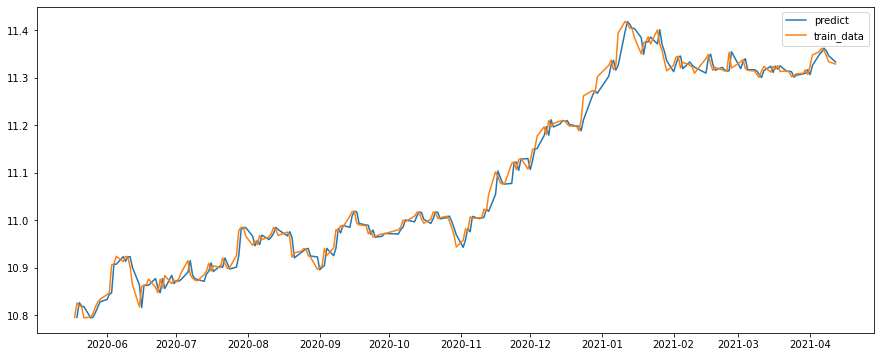

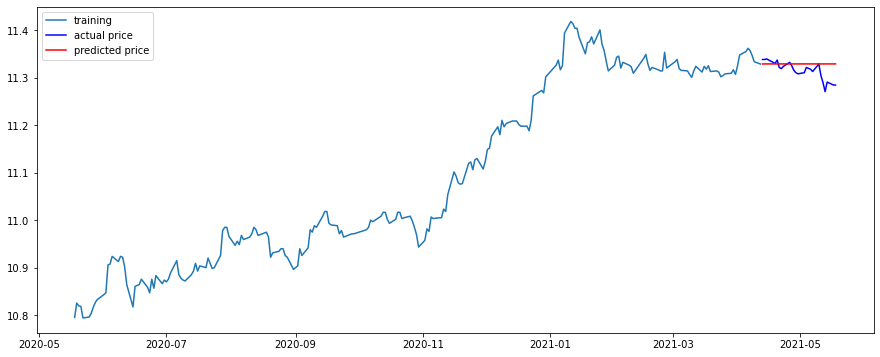

MSE:  3554742.108341229
MAE:  1417.6195615035942
RMSE:  1885.4023730602519
MAPE: 1.75%


In [27]:
show_result_of_ARIMA_model(1,1,3)

#### 7. ARIMA(1,2,1)

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at 

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 579.568
Date:                Fri, 18 Feb 2022   AIC                          -1153.136
Time:                        09:11:44   BIC                          -1142.914
Sample:                             0   HQIC                         -1149.009
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0212      0.061      0.347      0.729      -0.098       0.141
ma.L1         -0.9965      0.049    -20.444      0.000      -1.092      -0.901
sigma2         0.0003   2.65e-05     11.937      0.0

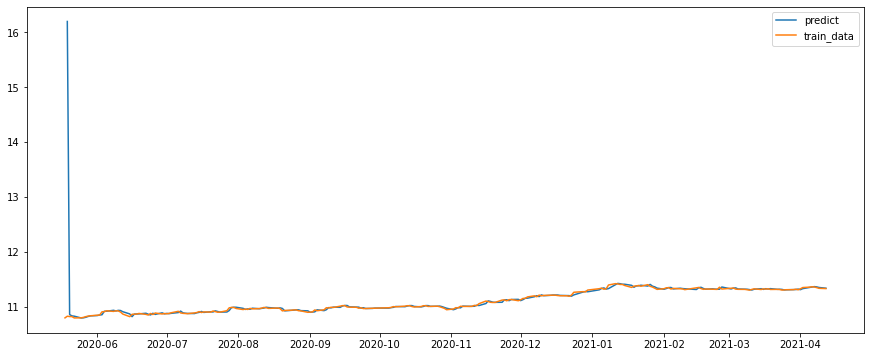

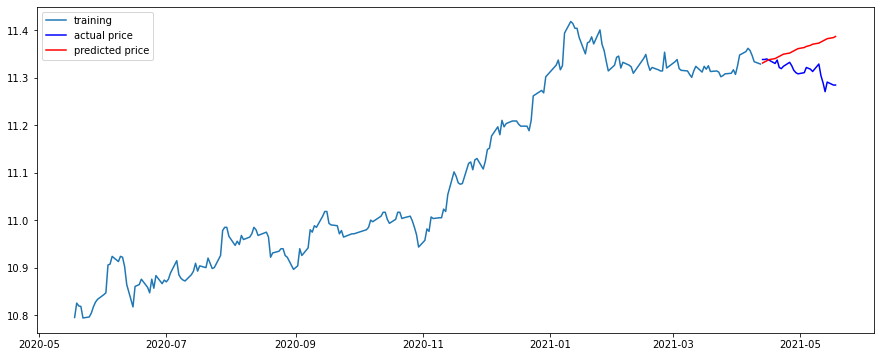

MSE:  21397195.83275683
MAE:  3727.5798934235495
RMSE:  4625.710305753791
MAPE: 4.60%


In [28]:
show_result_of_ARIMA_model(1,2,1)

#### 8. ARIMA(1,2,2)

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 2, 2)   Log Likelihood                 579.547
Date:                Fri, 18 Feb 2022   AIC                          -1151.093
Time:                        09:11:44   BIC                          -1137.464
Sample:                             0   HQIC                         -1145.591
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0000    131.805     -0.008      0.994    -259.333     257.333
ma.L1      -6.475e-06    139.153  -4.65e-08      1.000    -272.736     272.736
ma.L2         -1.0000    139.149     -0.007      0.9

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


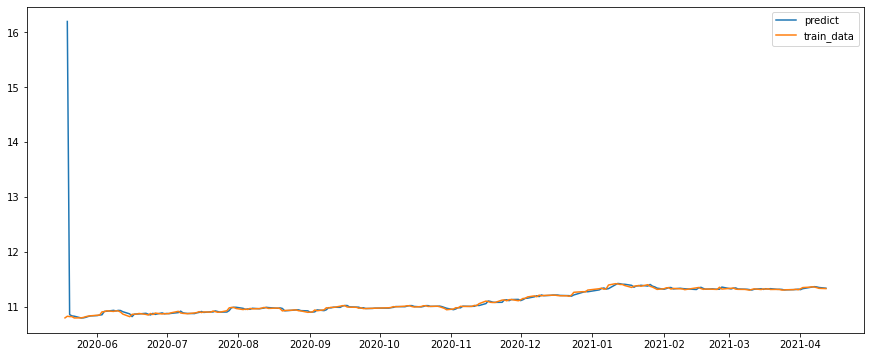

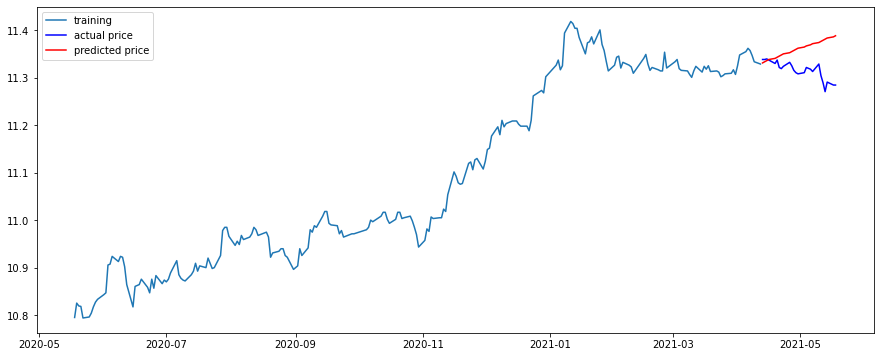

MSE:  22147144.008895896
MAE:  3797.696845275761
RMSE:  4706.075223463379
MAPE: 4.69%


In [29]:
show_result_of_ARIMA_model(1,2,2)

#### 9. ARIMA(1,2,3)

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 2, 3)   Log Likelihood                 580.139
Date:                Fri, 18 Feb 2022   AIC                          -1150.277
Time:                        09:11:45   BIC                          -1133.242
Sample:                             0   HQIC                         -1143.400
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9772      0.063    -15.504      0.000      -1.101      -0.854
ma.L1          0.0024      6.864      0.000      1.000     -13.450      13.455
ma.L2         -0.9919      6.877     -0.144      0.8

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


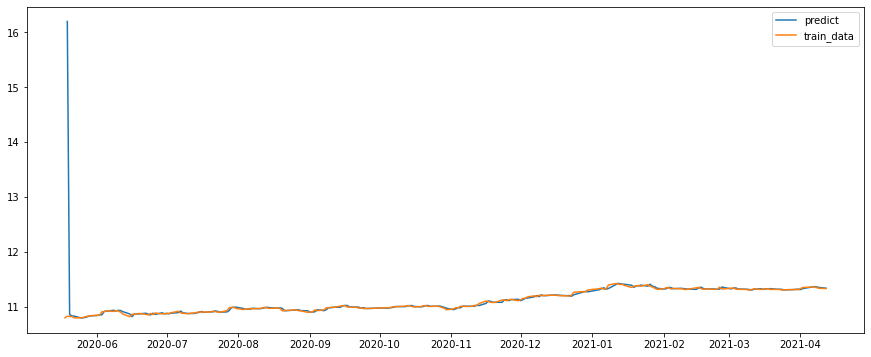

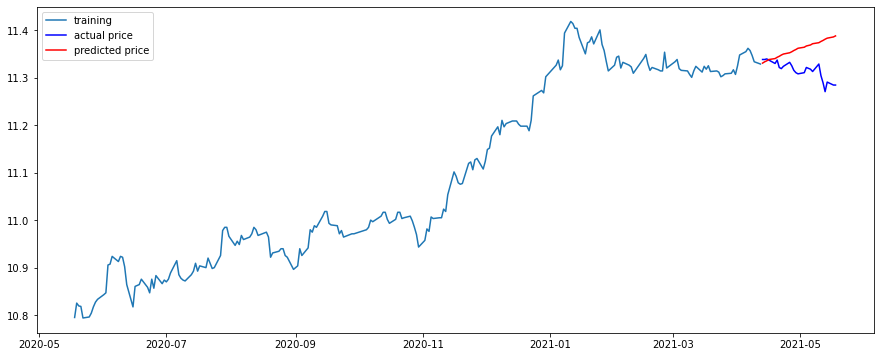

MSE:  21998959.117535237
MAE:  3783.165166856037
RMSE:  4690.304800067394
MAPE: 4.67%


In [30]:
show_result_of_ARIMA_model(1,2,3)

#### 삼성 결과 정리
|p|d|q|MAPE|
|:---:|:---:|:---:|:---:|
|1|0|1|1.04%|
|1|0|2|1.14%|
|1|0|3|1.17%|
|1|1|1|1.74%|
|1|1|2|1.73%|
|1|1|3|1.75%|
|1|2|1|4.60%|
|1|2|2|4.69%|
|1|2|3|4.67%|

- p=1 고정
- d=0 의미는 no differencing
- MAPE 값이 낮을수록 성능이 좋다.

=> **ARIMA(1,0,1) 모델이 MAPE 1.04% 로 가장 성능이 좋다.**

### STEP 7 : 다른 주식 종목 예측해 보기
- 관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기

#### 1. 종목: 구글(Google)

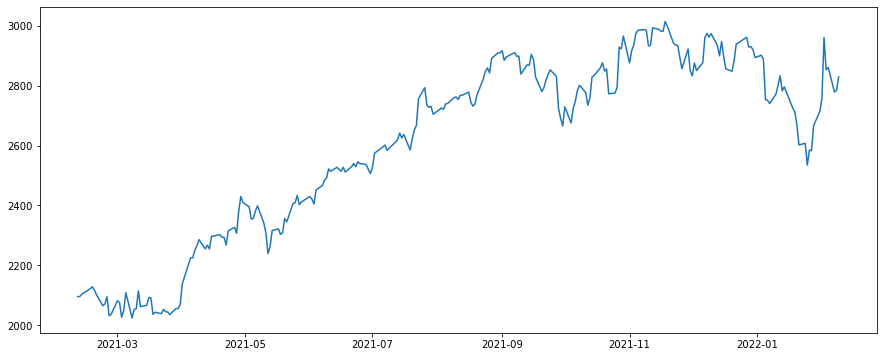

In [31]:
# STEP 1 : 시계열 데이터 준비

# Time Series 생성
dataset_filepath = 'stock_prediction/data/GOOG_220209.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']  # 종가(Close)
ts.head()

# 시계열 데이터 시각화
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.figure(figsize=(15,6))
plt.plot(ts)

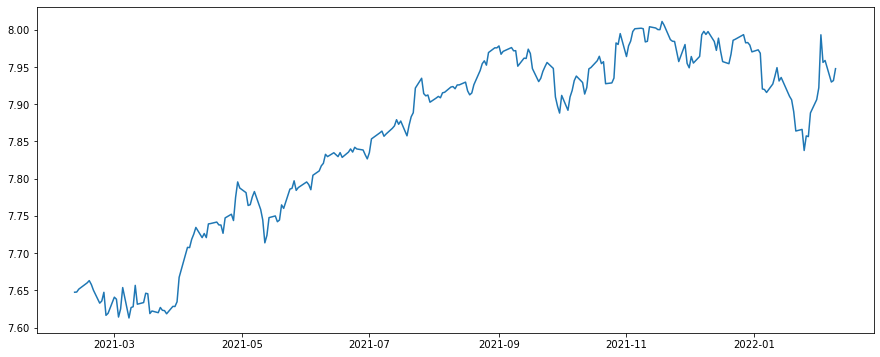

In [32]:
# STEP 2 : 각종 전처리 수행

# 1) 결측치 처리
ts = ts.interpolate(method='time') # 결측치가 있다면 보간합니다. 보간 기준은 time을 선택합니다. 
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

# 2) 로그 변환
ts_log = np.log(ts)
plt.figure(figsize=(15,6))
plt.plot(ts_log)

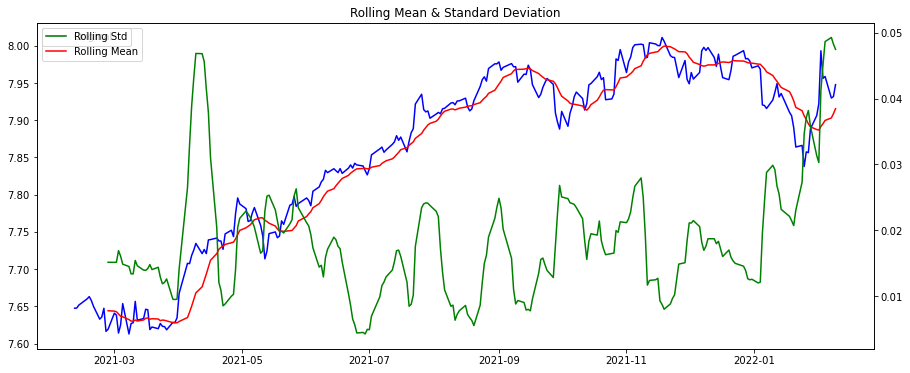

Results of Dickey-Fuller Test:
Test Statistic                  -1.622720
p-value                          0.471303
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


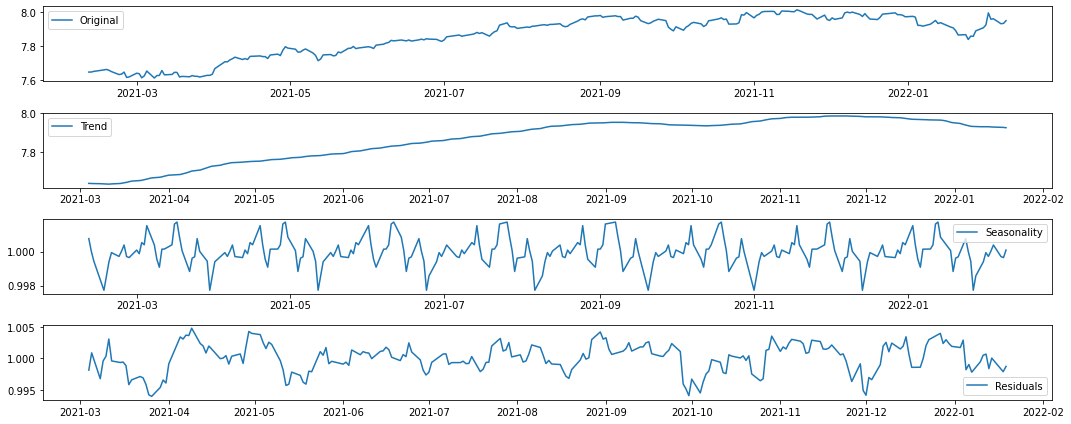

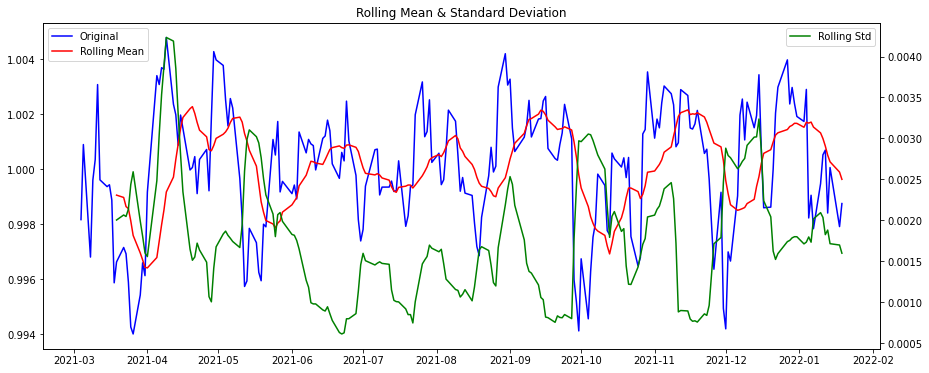

Results of Dickey-Fuller Test:
Test Statistic                  -5.612618
p-value                          0.000001
#Lags Used                       6.000000
Number of Observations Used    216.000000
Critical Value (1%)             -3.460992
Critical Value (5%)             -2.875016
Critical Value (10%)            -2.573952
dtype: float64


In [33]:
# STEP 3 : 시계열 안정성 분석

# 1) 정성적 그래프 분석: 구간 통계치(Rolling Statistics) 시각화
plot_rolling_statistics(ts_log, window=12)

# 2) 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 3) 시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend  # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal  # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid  # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (15,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# 4) Residual 안정성 확인
residual.dropna(inplace=True)
plot_rolling_statistics(residual)  # 정성적 그래프 분석
augmented_dickey_fuller_test(residual)  # 정량적 그래프 분석

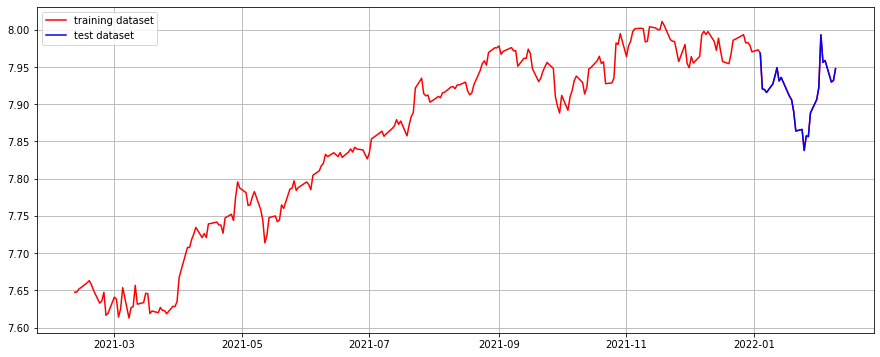

In [34]:
# STEP 4 : 학습, 테스트 데이터셋 생성

# 학습, 테스트 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(15,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

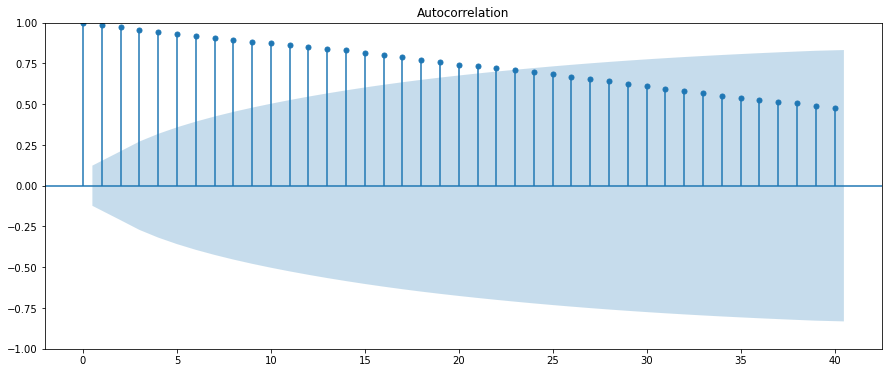

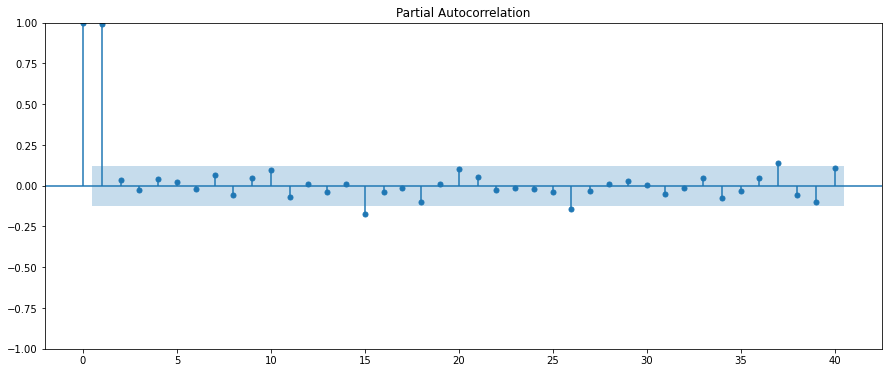

Results of Dickey-Fuller Test:
Test Statistic                -9.805433e+00
p-value                        5.843312e-17
#Lags Used                     2.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64


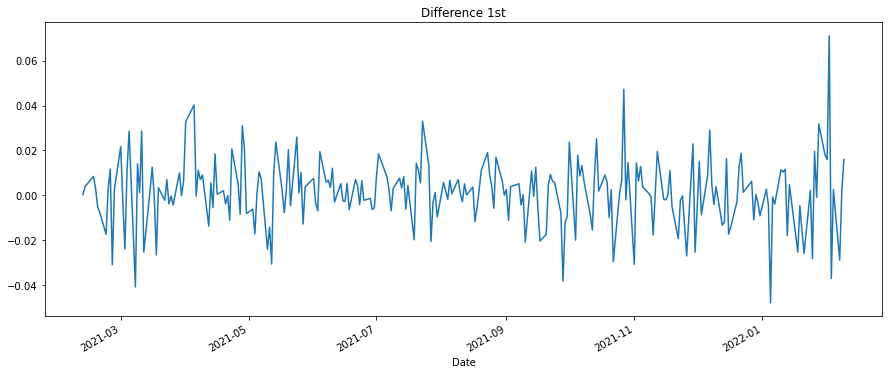

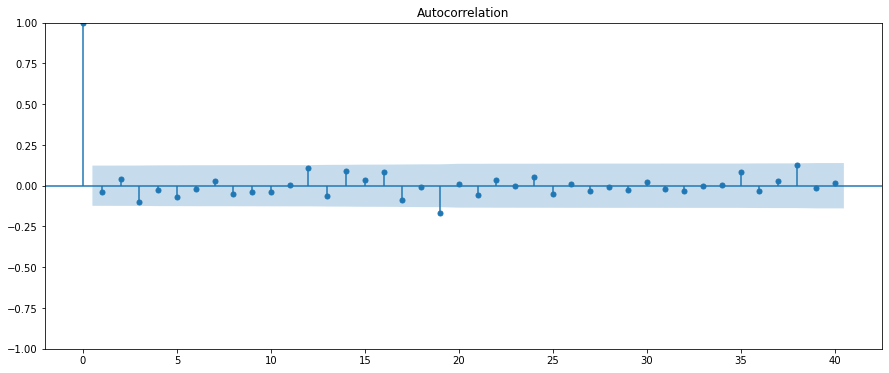

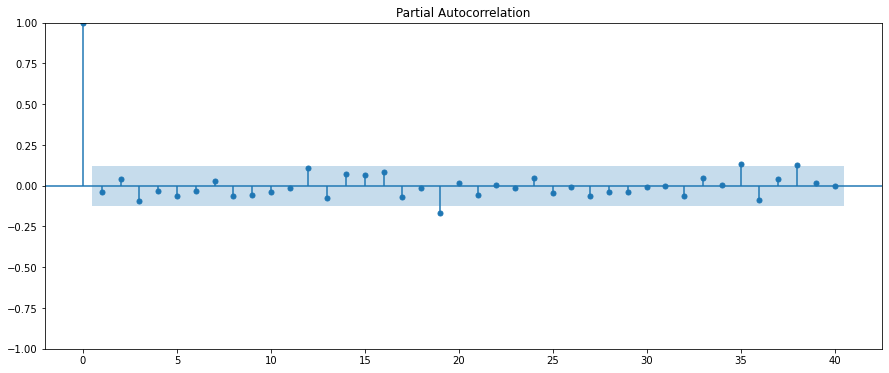

Results of Dickey-Fuller Test:
Test Statistic                -8.232185e+00
p-value                        6.021441e-13
#Lags Used                     1.400000e+01
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


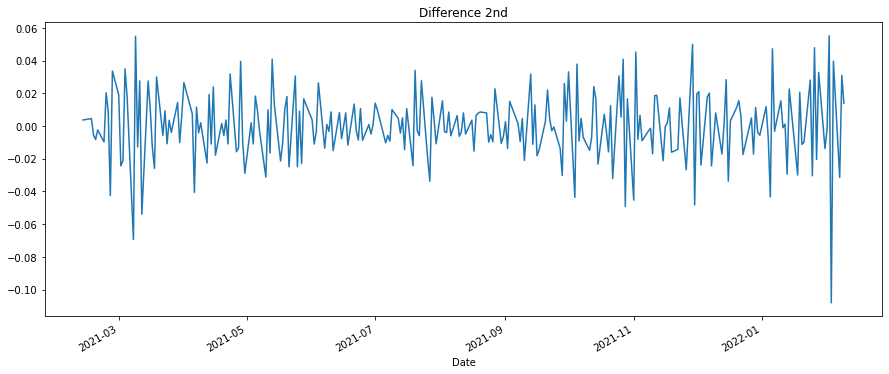

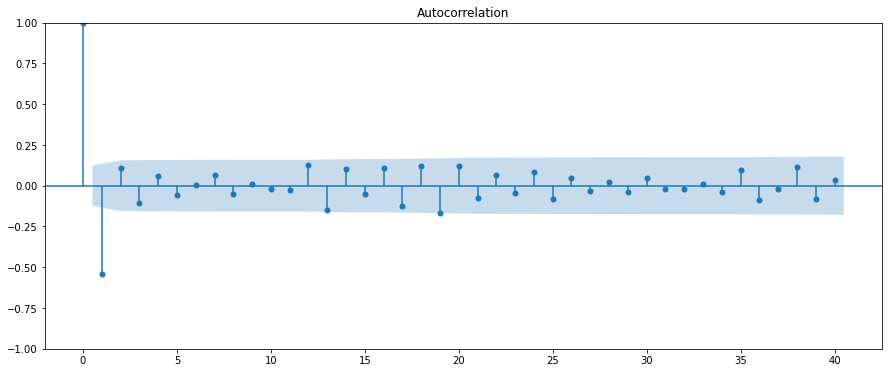

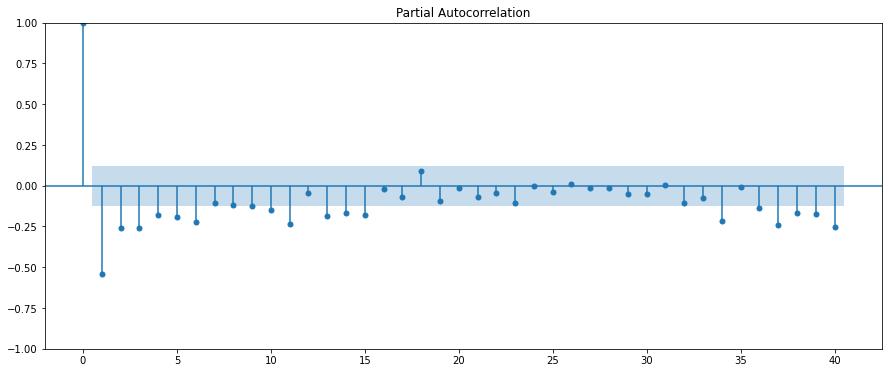

In [35]:
# STEP 5 : 적정 ARIMA 모수 찾기

# 1) ACF, PACF 그려보기 -> p,q 구하기
plot_acf(ts_log, lags=40)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log, lags=40)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

# 2) 차분 안정성 확인 -> d 구하기
# 2-1) 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 1차 차분 ACF, PACF 그려보기
plot_acf(diff_1, lags=40)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_1, lags=40)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

# 2-2) 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# 2차 차분 ACF, PACF 그려보기
plot_acf(diff_2, lags=40)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_2, lags=40)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- 실험할 ARIMA 모델 파라미터 결정

|p|d|q|
|:---:|:---:|:---:|
|1|0|1|
|1|0|2|
|1|0|3|
|1|1|1|
|1|1|2|
|1|1|3|
|1|2|1|

- p=1 고정
- d=0,1,2 사용
- d=2 일 때, q=1 고정
- q=1,2,3 로 실험

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at 

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 652.633
Date:                Fri, 18 Feb 2022   AIC                          -1297.265
Time:                        09:11:49   BIC                          -1283.565
Sample:                             0   HQIC                         -1291.737
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8308      0.057    138.103      0.000       7.720       7.942
ar.L1          0.9906      0.006    159.240      0.000       0.978       1.003
ma.L1         -0.0098      0.062     -0.157      0.8

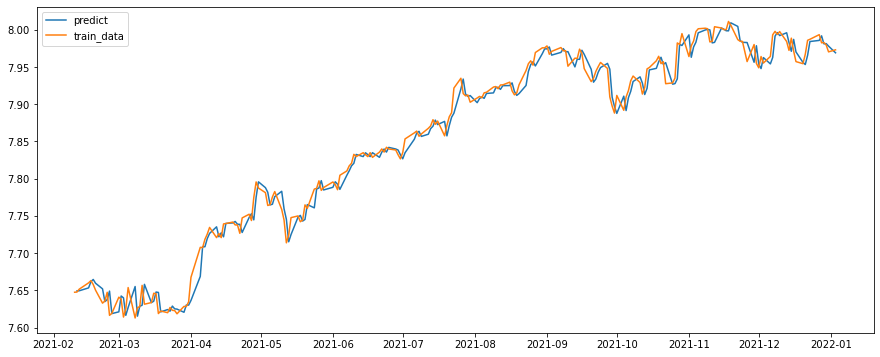

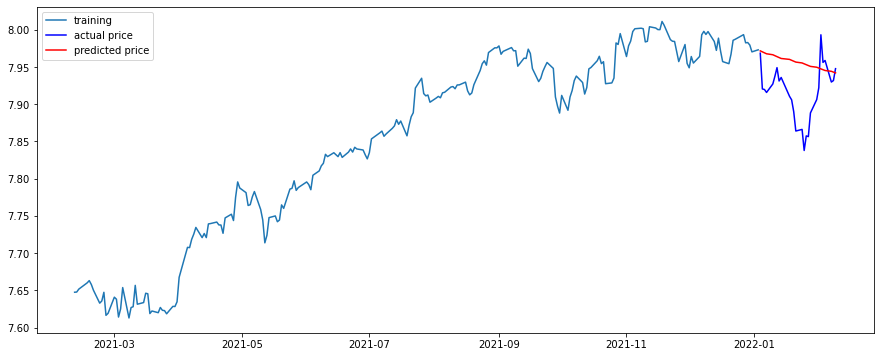

MSE:  22970.071561594126
MAE:  126.19437054606246
RMSE:  151.5588056220889
MAPE: 4.71%


In [36]:
# STEP 6 : ARIMA 모델 훈련과 테스트
show_result_of_ARIMA_model(1,0,1)

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at 

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 0, 2)   Log Likelihood                 652.850
Date:                Fri, 18 Feb 2022   AIC                          -1295.700
Time:                        09:11:49   BIC                          -1278.575
Sample:                             0   HQIC                         -1288.790
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8316      0.058    134.036      0.000       7.717       7.946
ar.L1          0.9913      0.006    165.850      0.000       0.980       1.003
ma.L1         -0.0205      0.062     -0.329      0.7

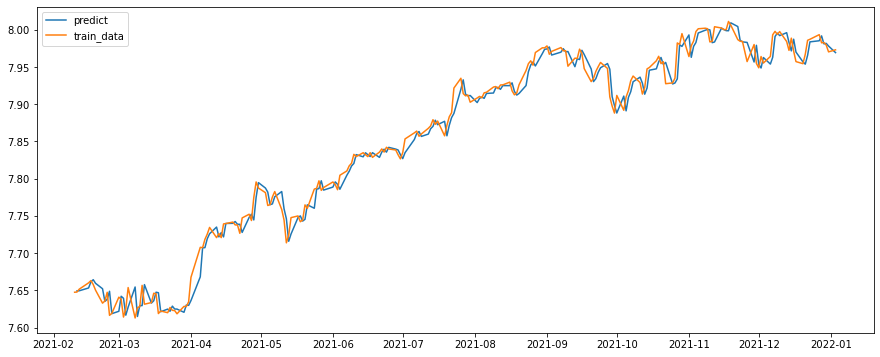

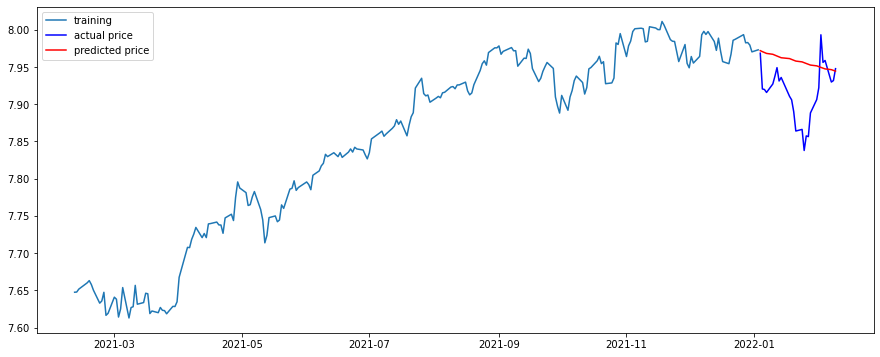

MSE:  23747.757395192242
MAE:  128.1889524361295
RMSE:  154.1030739316781
MAPE: 4.78%


In [37]:
# STEP 6 : ARIMA 모델 훈련과 테스트
show_result_of_ARIMA_model(1,0,2)

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 0, 3)   Log Likelihood                 654.044
Date:                Fri, 18 Feb 2022   AIC                          -1296.089
Time:                        09:11:50   BIC                          -1275.539
Sample:                             0   HQIC                         -1287.796
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8561      0.092     85.492      0.000       7.676       8.036
ar.L1          0.9949      0.005    183.383      0.000       0.984       1.006
ma.L1          0.0138      0.061      0.226      0.8

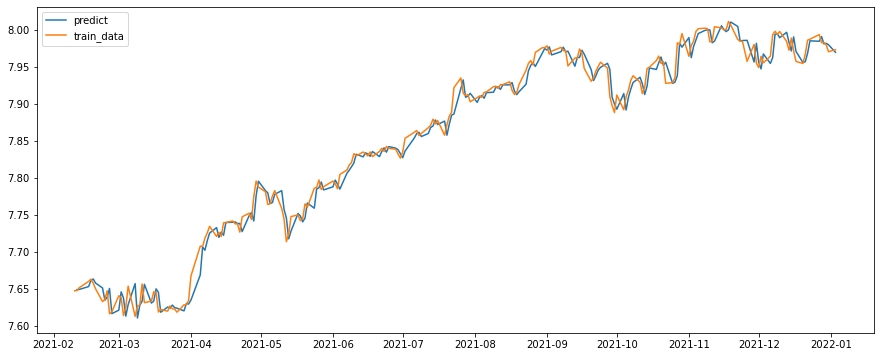

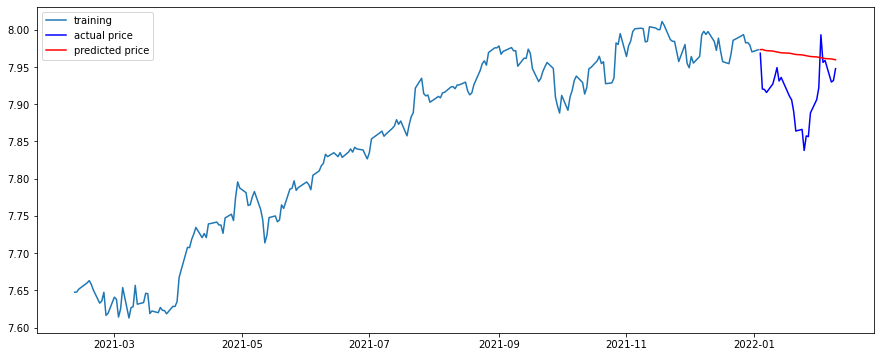

MSE:  29829.30326867524
MAE:  146.0215977055429
RMSE:  172.71161880045952
MAPE: 5.45%


In [38]:
# STEP 6 : ARIMA 모델 훈련과 테스트
show_result_of_ARIMA_model(1,0,3)

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 652.474
Date:                Fri, 18 Feb 2022   AIC                          -1298.948
Time:                        09:11:51   BIC                          -1288.686
Sample:                             0   HQIC                         -1294.806
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0130      2.530     -0.005      0.996      -4.972       4.946
ma.L1         -0.0130      2.530     -0.005      0.996      -4.972       4.946
sigma2         0.0002    1.4e-05     13.017      0.0

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at 

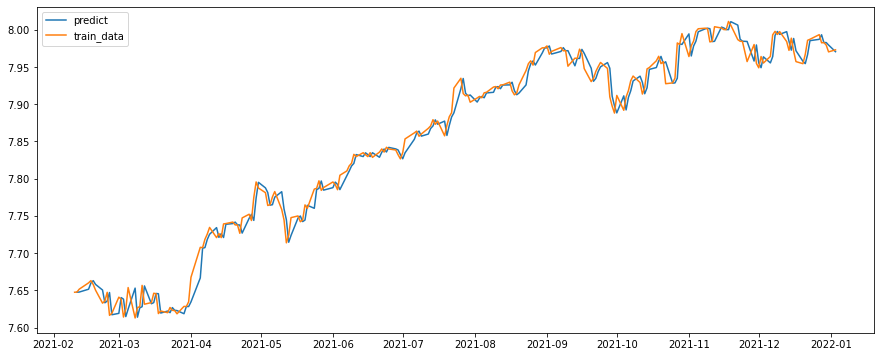

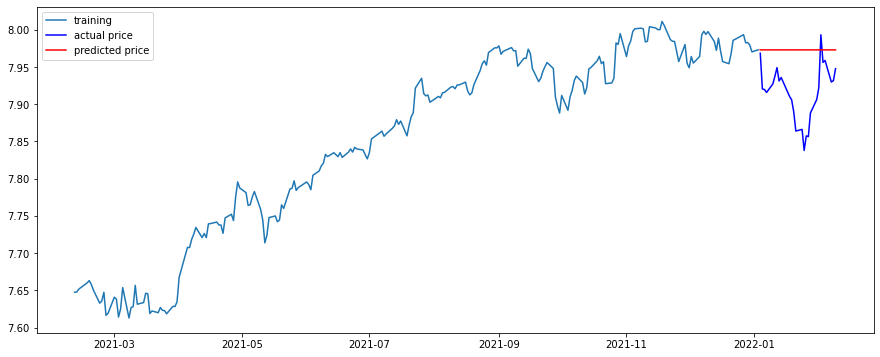

MSE:  35087.25178461811
MAE:  162.0479762458315
RMSE:  187.31591439228572
MAPE: 6.04%


In [39]:
# STEP 6 : ARIMA 모델 훈련과 테스트
show_result_of_ARIMA_model(1,1,1)

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 652.480
Date:                Fri, 18 Feb 2022   AIC                          -1296.960
Time:                        09:11:51   BIC                          -1283.278
Sample:                             0   HQIC                         -1291.438
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3486     12.297     -0.028      0.977     -24.451      23.753
ma.L1          0.3205     12.298      0.026      0.979     -23.784      24.425
ma.L2         -0.0137      0.328     -0.042      0.9

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at 

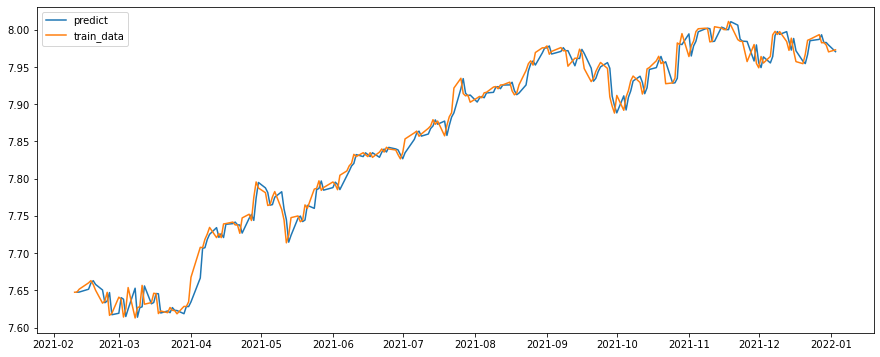

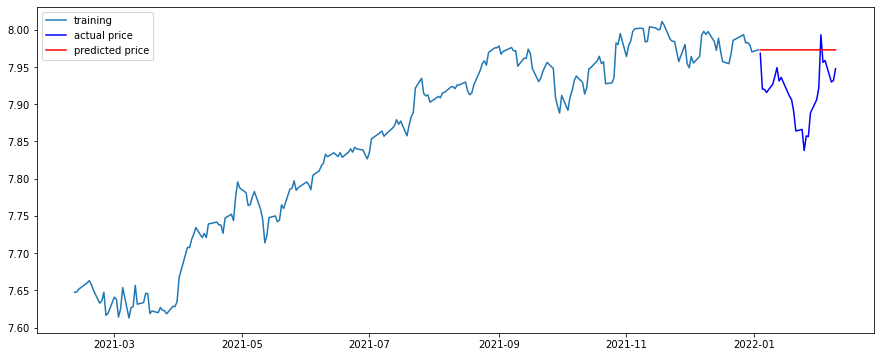

MSE:  35098.4154118358
MAE:  162.08222012874782
RMSE:  187.3457109512673
MAPE: 6.04%


In [40]:
# STEP 6 : ARIMA 모델 훈련과 테스트
show_result_of_ARIMA_model(1,1,2)

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 1, 3)   Log Likelihood                 655.228
Date:                Fri, 18 Feb 2022   AIC                          -1300.455
Time:                        09:11:52   BIC                          -1283.353
Sample:                             0   HQIC                         -1293.553
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6804      0.258     -2.634      0.008      -1.187      -0.174
ma.L1          0.6659      0.253      2.630      0.009       0.170       1.162
ma.L2         -0.0730      0.077     -0.954      0.3

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


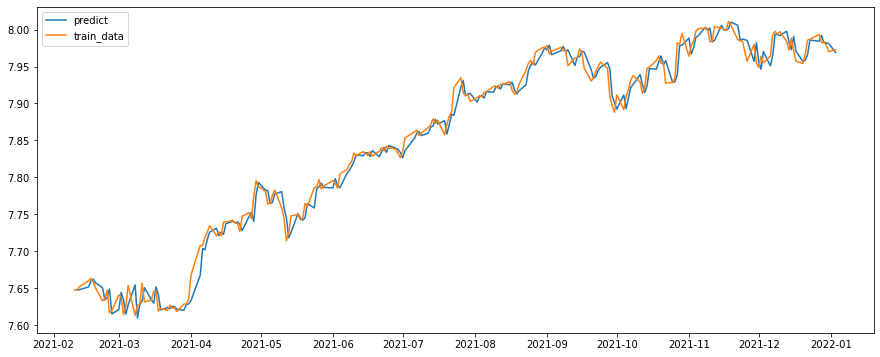

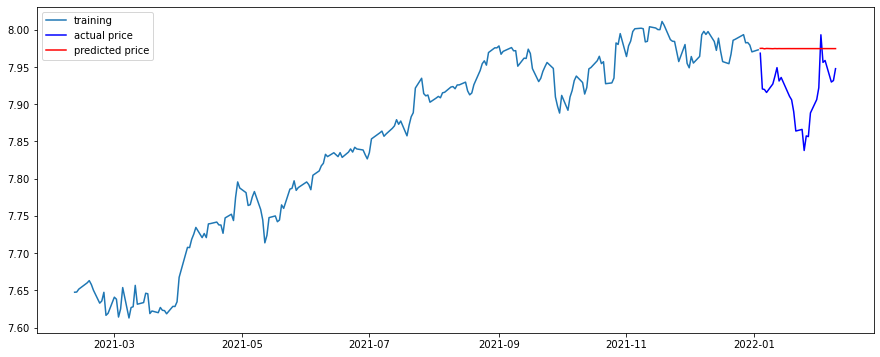

MSE:  36696.69968382948
MAE:  166.71708720456144
RMSE:  191.56382665793006
MAPE: 6.21%


In [41]:
# STEP 6 : ARIMA 모델 훈련과 테스트
show_result_of_ARIMA_model(1,1,3)

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 647.654
Date:                Fri, 18 Feb 2022   AIC                          -1289.308
Time:                        09:11:53   BIC                          -1279.060
Sample:                             0   HQIC                         -1285.172
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0316      0.061     -0.516      0.606      -0.152       0.089
ma.L1         -0.9943      0.042    -23.791      0.000      -1.076      -0.912
sigma2         0.0002   1.54e-05     11.804      0.0

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


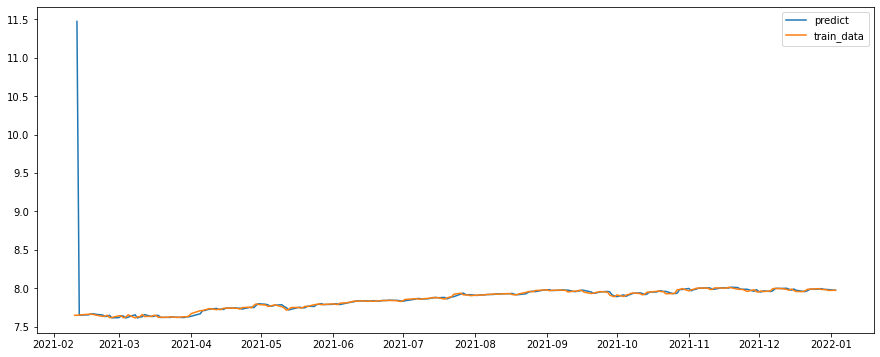

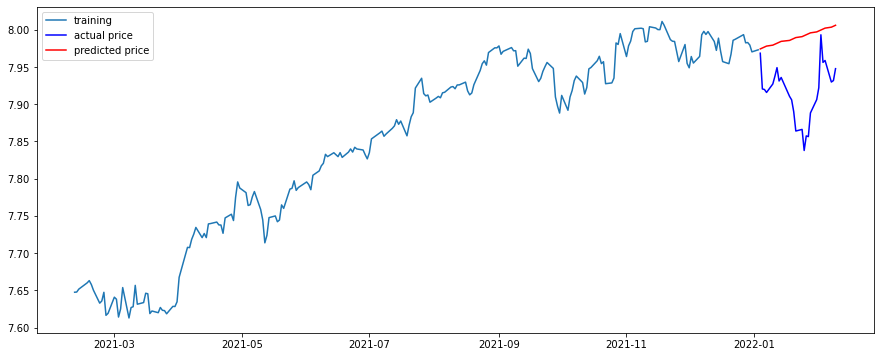

MSE:  54126.72019650575
MAE:  207.84384034956676
RMSE:  232.6514994503705
MAPE: 7.72%


In [42]:
# STEP 6 : ARIMA 모델 훈련과 테스트
show_result_of_ARIMA_model(1,2,1)

- 구글 결과 정리

|p|d|q|MAPE|
|:---:|:---:|:---:|:---:|
|1|0|1|4.71%|
|1|0|2|4.78%|
|1|0|3|5.45%|
|1|1|1|6.04%|
|1|1|2|6.04%|
|1|1|3|6.21%|
|1|2|1|7.72%|

- p=1 고정
- d=0 의미는 no differencing
- MAPE 값이 낮을수록 성능이 좋다.

=> **ARIMA(1,0,1) 모델이 MAPE 4.71% 로 가장 성능이 좋다.**

#### 2. 종목: 아마존(Amazon)

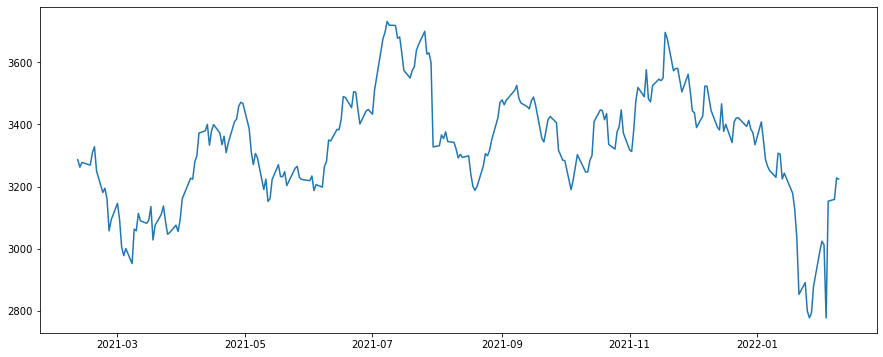

In [43]:
# STEP 1 : 시계열 데이터 준비

# Time Series 생성
dataset_filepath = 'stock_prediction/data/AMZN_220209.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']  # 종가(Close)
ts.head()

# 시계열 데이터 시각화
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.figure(figsize=(15,6))
plt.plot(ts)

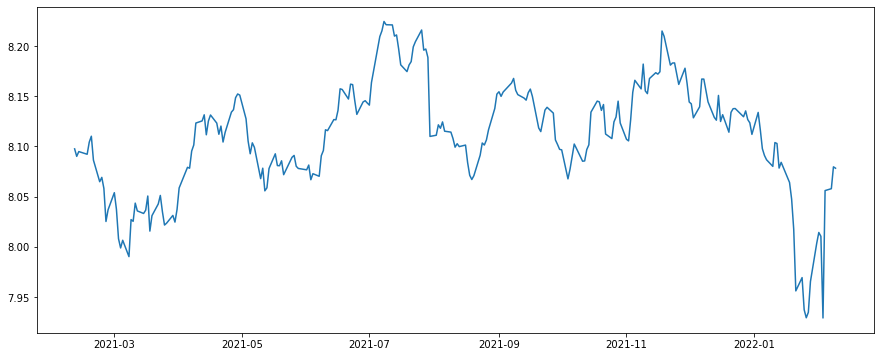

In [44]:
# STEP 2 : 각종 전처리 수행

# 1) 결측치 처리
ts = ts.interpolate(method='time') # 결측치가 있다면 보간합니다. 보간 기준은 time을 선택합니다. 
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

# 2) 로그 변환
ts_log = np.log(ts)
plt.figure(figsize=(15,6))
plt.plot(ts_log)

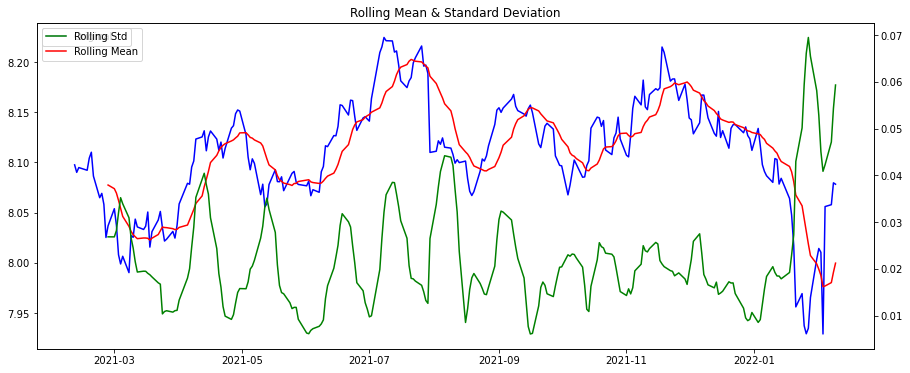

Results of Dickey-Fuller Test:
Test Statistic                  -2.609828
p-value                          0.090983
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


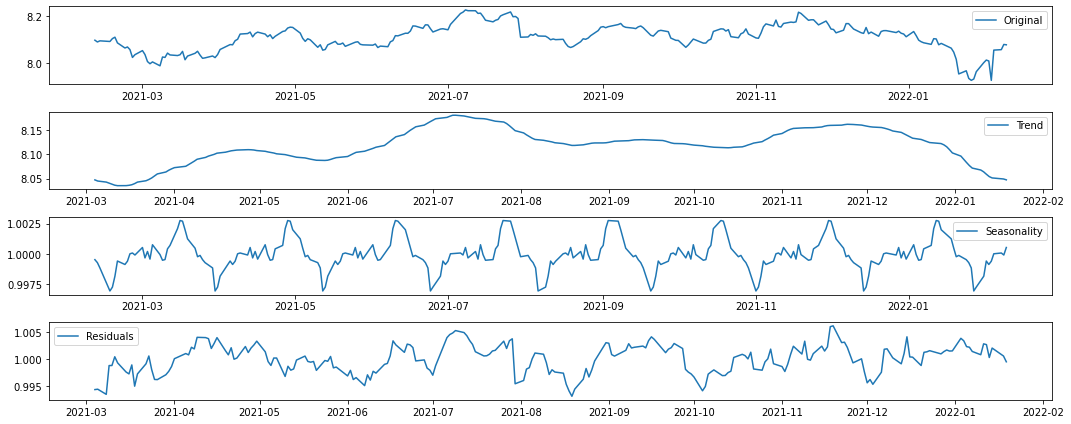

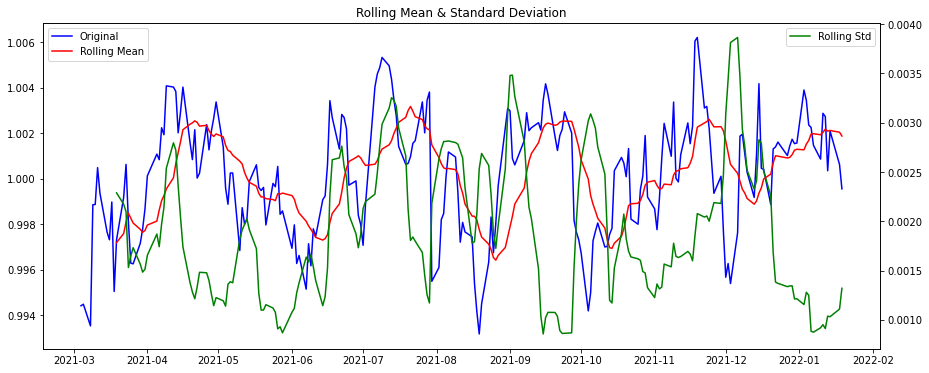

Results of Dickey-Fuller Test:
Test Statistic                  -5.159380
p-value                          0.000011
#Lags Used                       0.000000
Number of Observations Used    222.000000
Critical Value (1%)             -3.460154
Critical Value (5%)             -2.874649
Critical Value (10%)            -2.573757
dtype: float64


In [45]:
# STEP 3 : 시계열 안정성 분석

# 1) 정성적 그래프 분석: 구간 통계치(Rolling Statistics) 시각화
plot_rolling_statistics(ts_log, window=12)

# 2) 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 3) 시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend  # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal  # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid  # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (15,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# 4) Residual 안정성 확인
residual.dropna(inplace=True)
plot_rolling_statistics(residual)  # 정성적 그래프 분석
augmented_dickey_fuller_test(residual)  # 정량적 그래프 분석

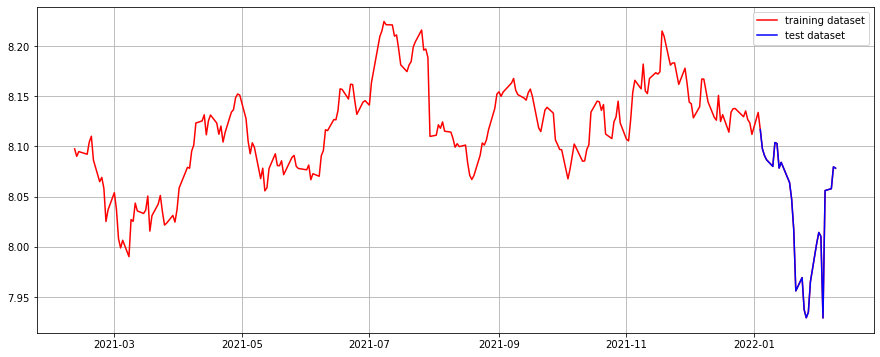

In [46]:
# STEP 4 : 학습, 테스트 데이터셋 생성

# 학습, 테스트 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(15,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

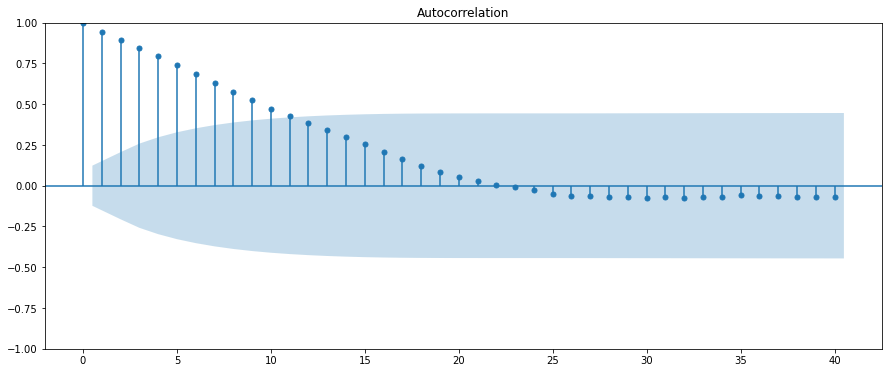

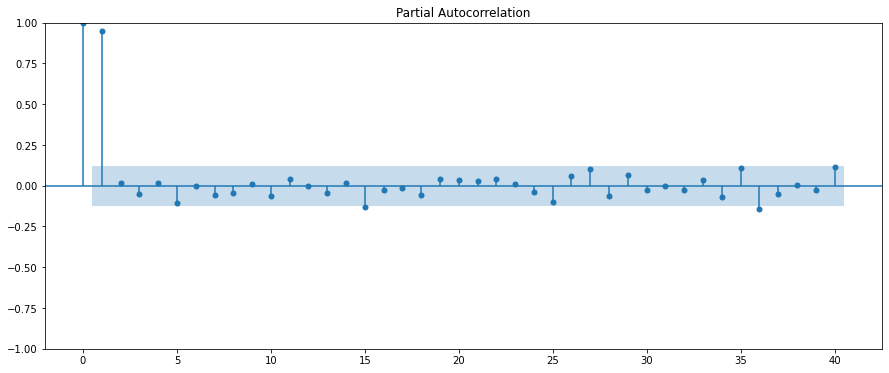

Results of Dickey-Fuller Test:
Test Statistic                -1.647015e+01
p-value                        2.287111e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


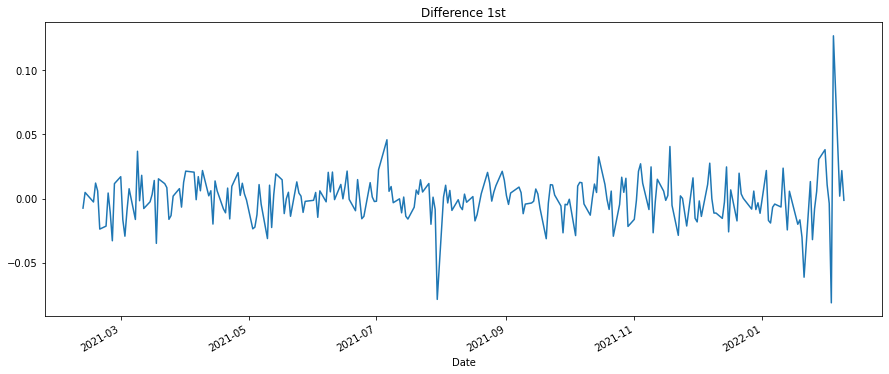

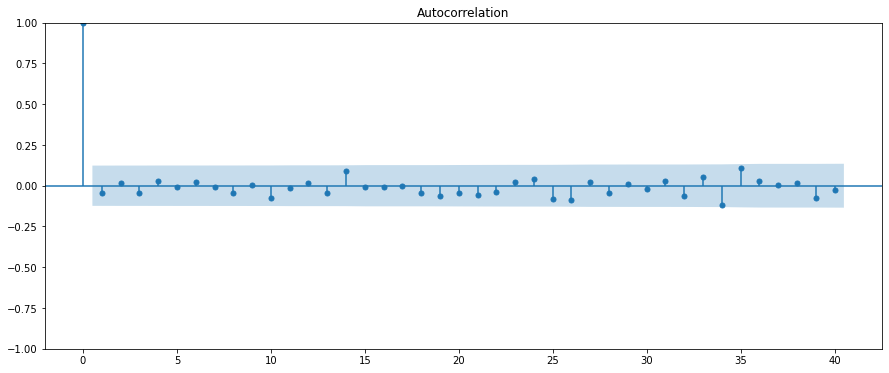

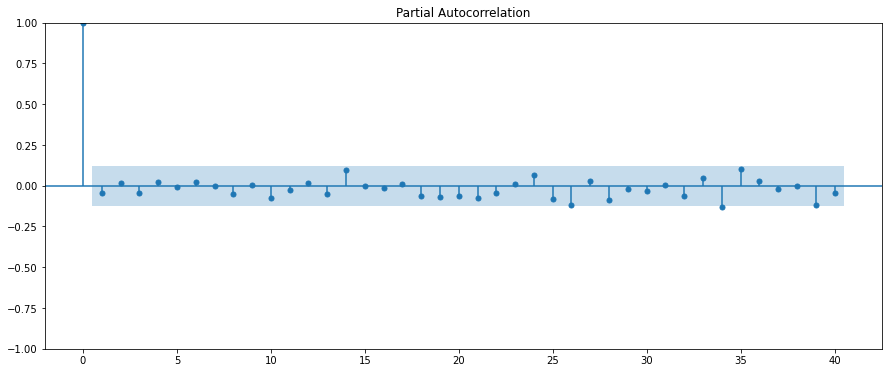

Results of Dickey-Fuller Test:
Test Statistic                -7.881075e+00
p-value                        4.701185e-12
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


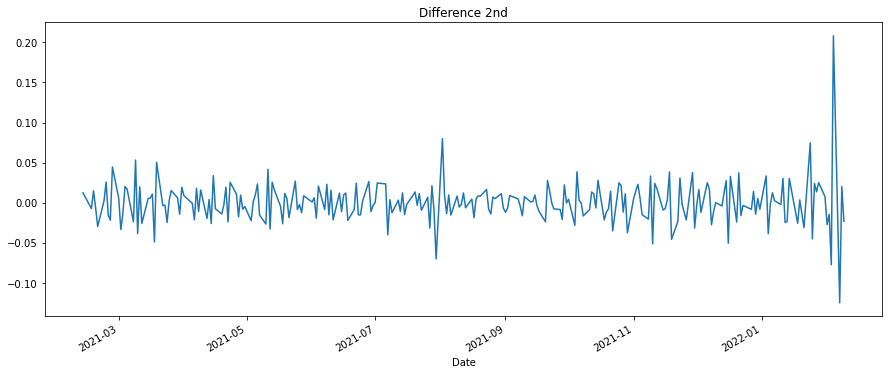

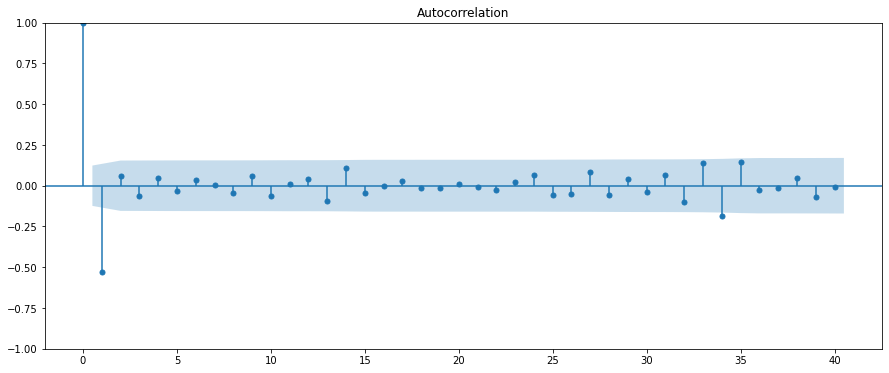

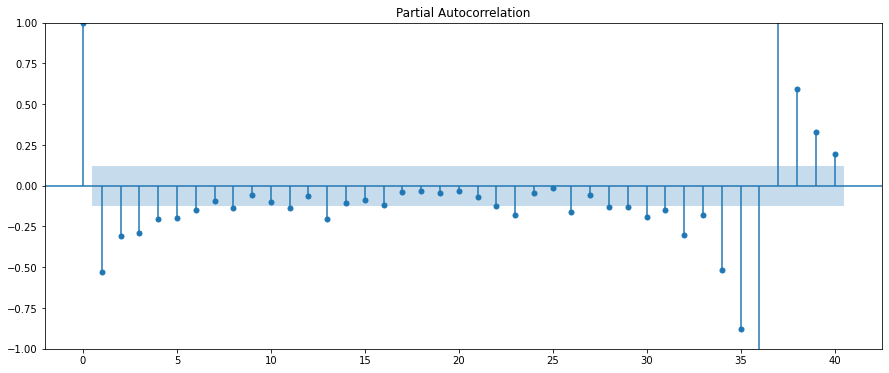

In [47]:
# STEP 5 : 적정 ARIMA 모수 찾기

# 1) ACF, PACF 그려보기 -> p,q 구하기
plot_acf(ts_log, lags=40)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log, lags=40)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

# 2) 차분 안정성 확인 -> d 구하기
# 2-1) 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 1차 차분 ACF, PACF 그려보기
plot_acf(diff_1, lags=40)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_1, lags=40)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

# 2-2) 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# 2차 차분 ACF, PACF 그려보기
plot_acf(diff_2, lags=40)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_2, lags=40)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- 실험할 ARIMA 모델 파라미터 결정

|p|d|q|
|:---:|:---:|:---:|
|1|0|1|
|1|0|2|
|1|0|3|
|1|1|1|
|1|1|2|
|1|1|3|
|1|2|1|

- p=1 고정
- d=0,1,2 사용
- d=2 일 때, q=1 고정
- q=1,2,3 로 실험

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at 

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 634.478
Date:                Fri, 18 Feb 2022   AIC                          -1260.955
Time:                        09:11:57   BIC                          -1247.255
Sample:                             0   HQIC                         -1255.427
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.1175      0.019    422.677      0.000       8.080       8.155
ar.L1          0.9430      0.021     44.124      0.000       0.901       0.985
ma.L1          0.0949      0.079      1.200      0.2

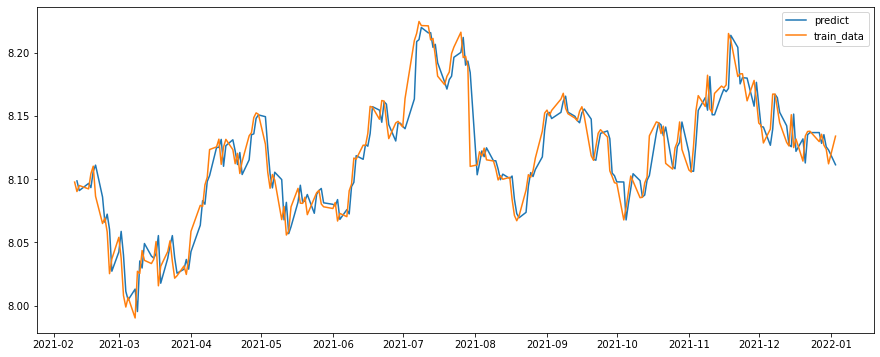

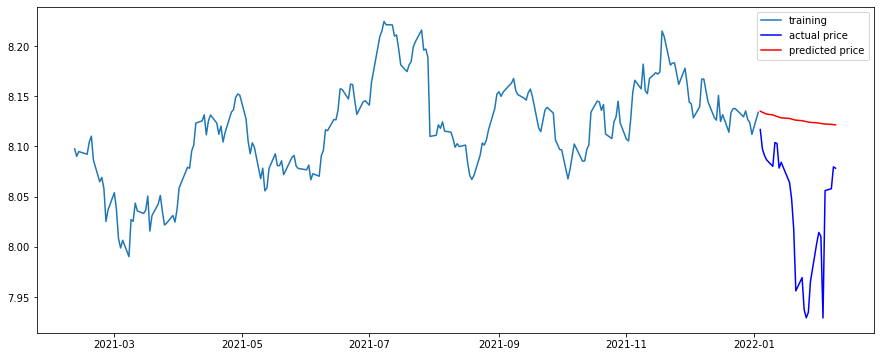

MSE:  117920.48087661185
MAE:  293.14288406301233
RMSE:  343.3955166810013
MAPE: 9.88%


In [48]:
# STEP 6 : ARIMA 모델 훈련과 테스트
show_result_of_ARIMA_model(1,0,1)

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 0, 2)   Log Likelihood                 634.501
Date:                Fri, 18 Feb 2022   AIC                          -1259.001
Time:                        09:11:57   BIC                          -1241.877
Sample:                             0   HQIC                         -1252.091
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.1175      0.020    408.718      0.000       8.079       8.156
ar.L1          0.9458      0.022     42.828      0.000       0.902       0.989
ma.L1          0.0928      0.084      1.102      0.2

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at 

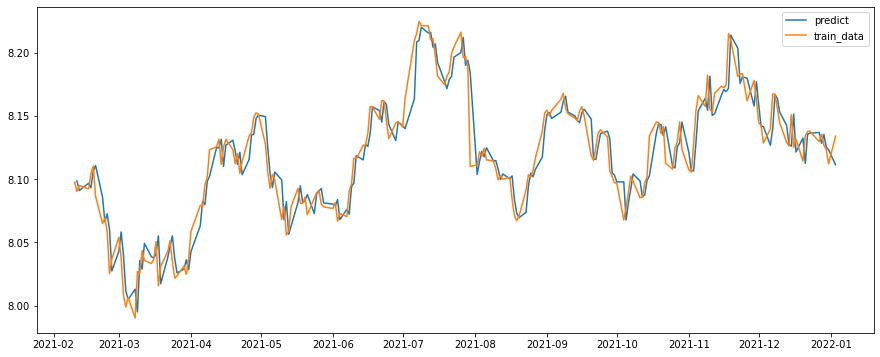

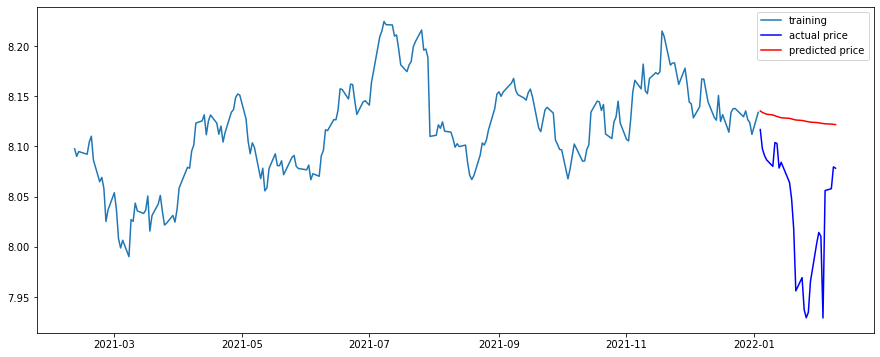

MSE:  118256.72446125576
MAE:  293.573291214927
RMSE:  343.88475462174205
MAPE: 9.90%


In [49]:
# STEP 6 : ARIMA 모델 훈련과 테스트
show_result_of_ARIMA_model(1,0,2)

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 0, 3)   Log Likelihood                 634.574
Date:                Fri, 18 Feb 2022   AIC                          -1257.148
Time:                        09:11:58   BIC                          -1236.598
Sample:                             0   HQIC                         -1248.855
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.1175      0.019    429.463      0.000       8.080       8.155
ar.L1          0.9441      0.023     41.589      0.000       0.900       0.989
ma.L1          0.0914      0.085      1.076      0.2

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


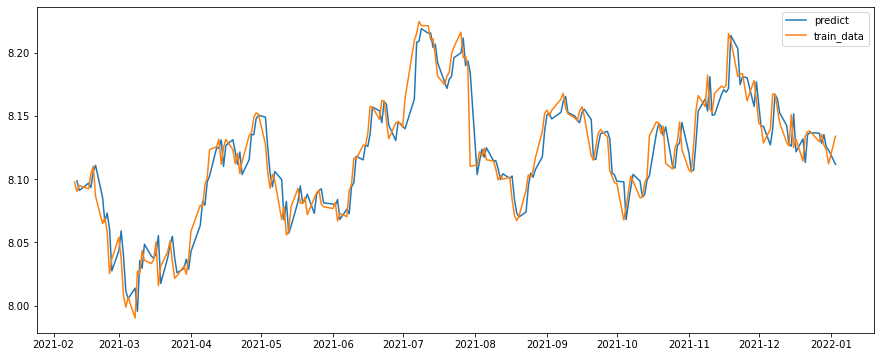

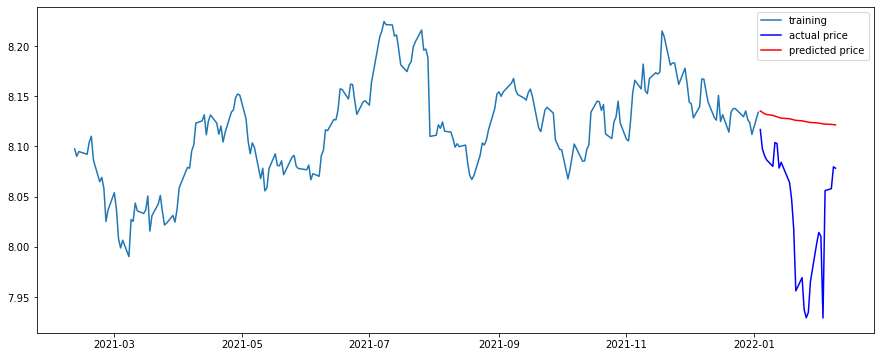

MSE:  117625.1880989458
MAE:  292.55980831500534
RMSE:  342.9652870174266
MAPE: 9.86%


In [50]:
# STEP 6 : ARIMA 모델 훈련과 테스트
show_result_of_ARIMA_model(1,0,3)

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 629.339
Date:                Fri, 18 Feb 2022   AIC                          -1252.678
Time:                        09:11:58   BIC                          -1242.417
Sample:                             0   HQIC                         -1248.537
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1841      1.215     -0.151      0.880      -2.566       2.198
ma.L1          0.2480      1.185      0.209      0.834      -2.075       2.571
sigma2         0.0002   1.43e-05     15.638      0.0

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at 

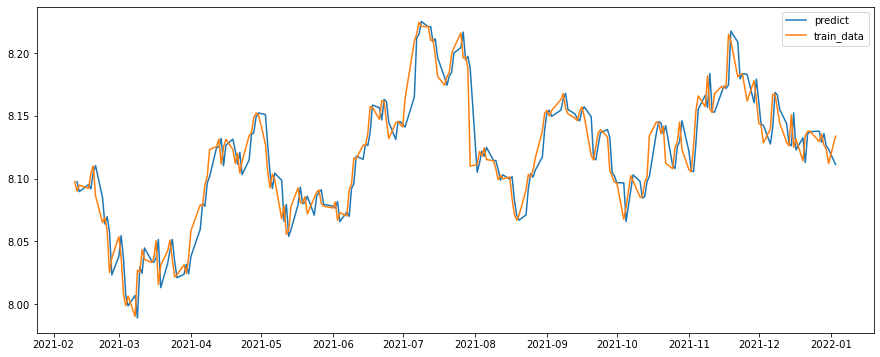

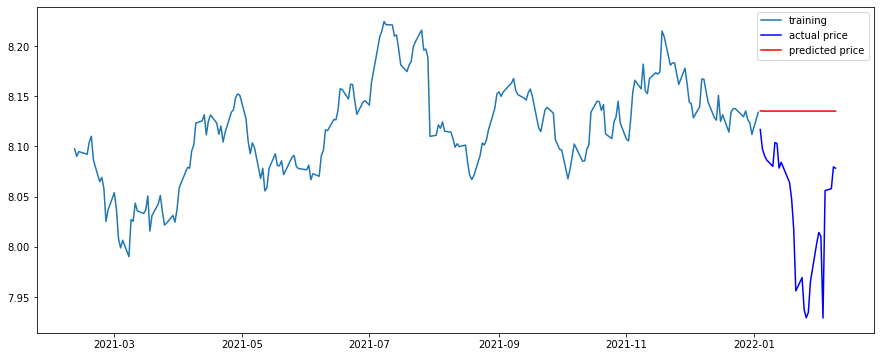

MSE:  138343.00746781993
MAE:  321.86156075987253
RMSE:  371.94489842961946
MAPE: 10.83%


In [51]:
# STEP 6 : ARIMA 모델 훈련과 테스트
show_result_of_ARIMA_model(1,1,1)

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 629.459
Date:                Fri, 18 Feb 2022   AIC                          -1250.918
Time:                        09:11:59   BIC                          -1237.236
Sample:                             0   HQIC                         -1245.397
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0592      1.848     -0.032      0.974      -3.682       3.563
ma.L1          0.1188      1.845      0.064      0.949      -3.498       3.735
ma.L2         -0.0392      0.145     -0.270      0.7

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at 

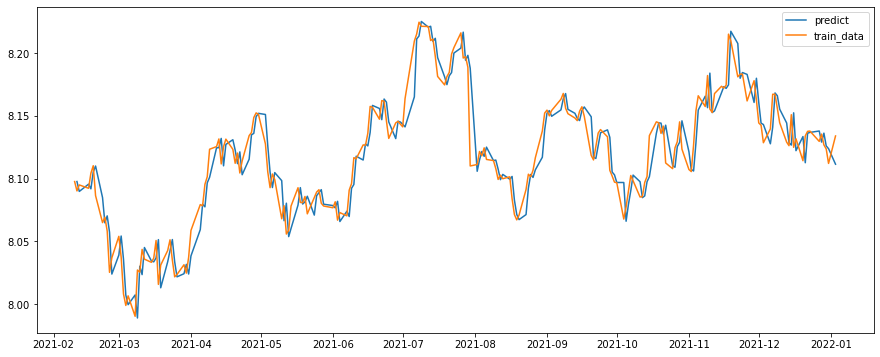

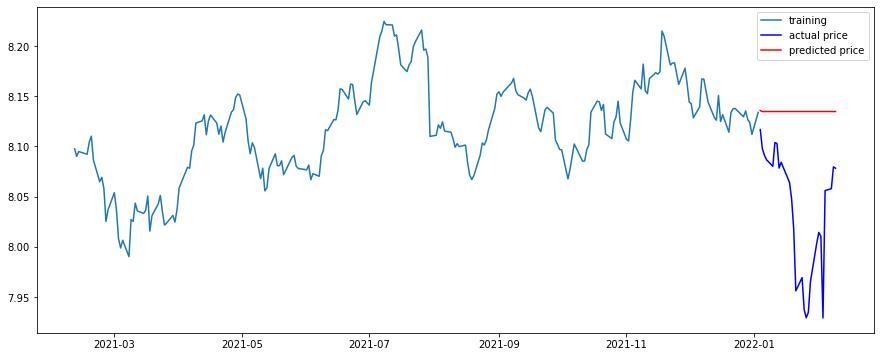

MSE:  137414.9842776569
MAE:  320.48830046434875
RMSE:  370.69527145305875
MAPE: 10.78%


In [52]:
# STEP 6 : ARIMA 모델 훈련과 테스트
show_result_of_ARIMA_model(1,1,2)

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 1, 3)   Log Likelihood                 631.651
Date:                Fri, 18 Feb 2022   AIC                          -1253.303
Time:                        09:12:00   BIC                          -1236.200
Sample:                             0   HQIC                         -1246.401
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9183      0.107     -8.598      0.000      -1.128      -0.709
ma.L1          1.0004      0.131      7.651      0.000       0.744       1.257
ma.L2          0.0064      0.121      0.053      0.9

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


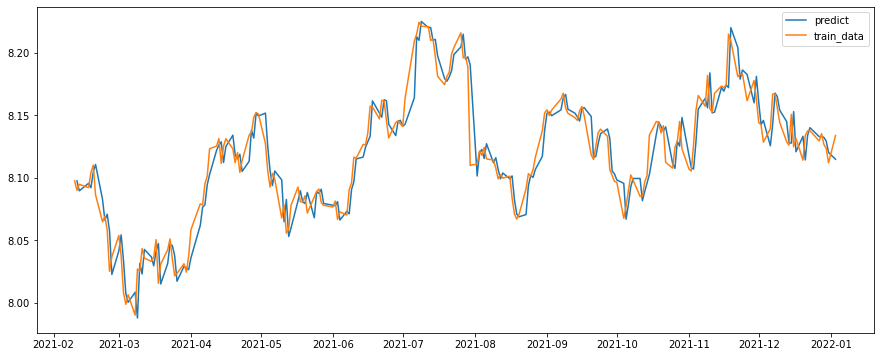

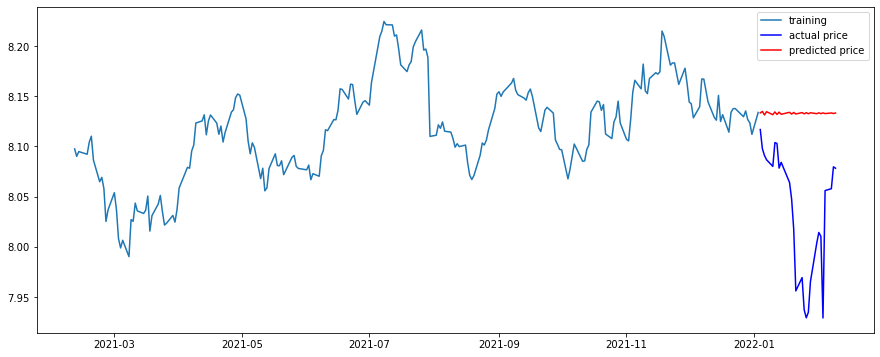

MSE:  133724.47839528084
MAE:  314.67934542553087
RMSE:  365.6835768738881
MAPE: 10.60%


In [53]:
# STEP 6 : ARIMA 모델 훈련과 테스트
show_result_of_ARIMA_model(1,1,3)

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 623.294
Date:                Fri, 18 Feb 2022   AIC                          -1240.588
Time:                        09:12:01   BIC                          -1230.339
Sample:                             0   HQIC                         -1236.451
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0657      0.081      0.810      0.418      -0.093       0.225
ma.L1         -0.9999      5.944     -0.168      0.866     -12.649      10.649
sigma2         0.0002      0.001      0.168      0.8

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


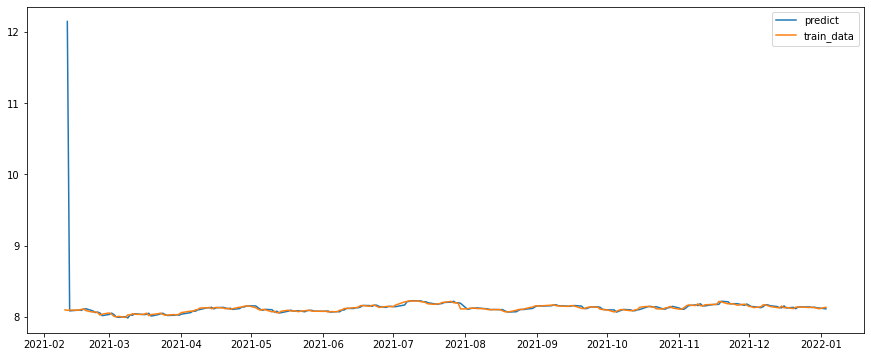

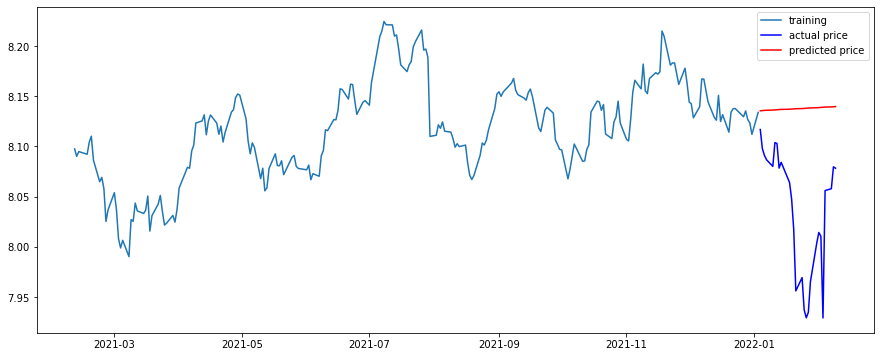

MSE:  144518.1940481522
MAE:  330.09643792745044
RMSE:  380.1554866737454
MAPE: 11.10%


In [54]:
# STEP 6 : ARIMA 모델 훈련과 테스트
show_result_of_ARIMA_model(1,2,1)

- 아마존 결과 정리

|p|d|q|MAPE|
|:---:|:---:|:---:|:---:|
|1|0|1|9.88%|
|1|0|2|9.90%|
|1|0|3|9.86%|
|1|1|1|10.83%|
|1|1|2|10.78%|
|1|1|3|10.60%|
|1|2|1|11.10%|

- p=1 고정
- d=0 의미는 no differencing
- MAPE 값이 낮을수록 성능이 좋다.

=> **ARIMA(1,0,1) 모델이 MAPE 9.88% 로 가장 성능이 좋다.**

#### 3. 종목: 애플(Apple)

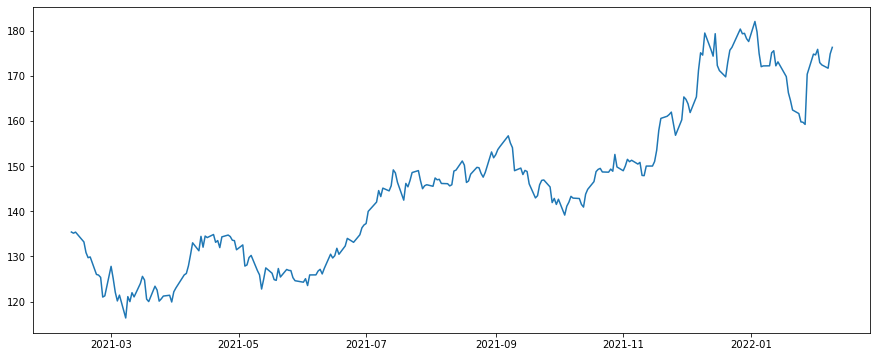

In [55]:
# STEP 1 : 시계열 데이터 준비

# Time Series 생성
dataset_filepath = 'stock_prediction/data/AAPL_220209.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']  # 종가(Close)
ts.head()

# 시계열 데이터 시각화
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.figure(figsize=(15,6))
plt.plot(ts)

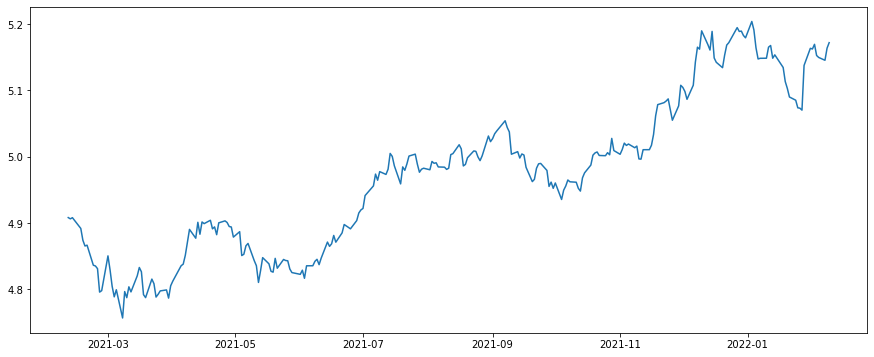

In [56]:
# STEP 2 : 각종 전처리 수행

# 1) 결측치 처리
ts = ts.interpolate(method='time') # 결측치가 있다면 보간합니다. 보간 기준은 time을 선택합니다. 
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

# 2) 로그 변환
ts_log = np.log(ts)
plt.figure(figsize=(15,6))
plt.plot(ts_log)

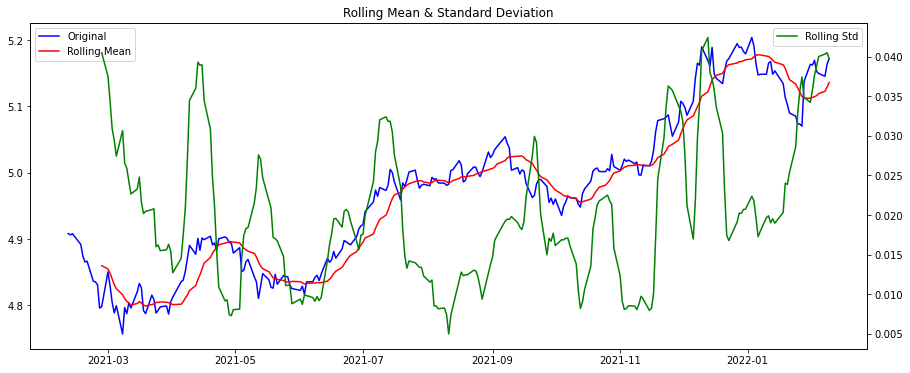

Results of Dickey-Fuller Test:
Test Statistic                  -0.410001
p-value                          0.908416
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


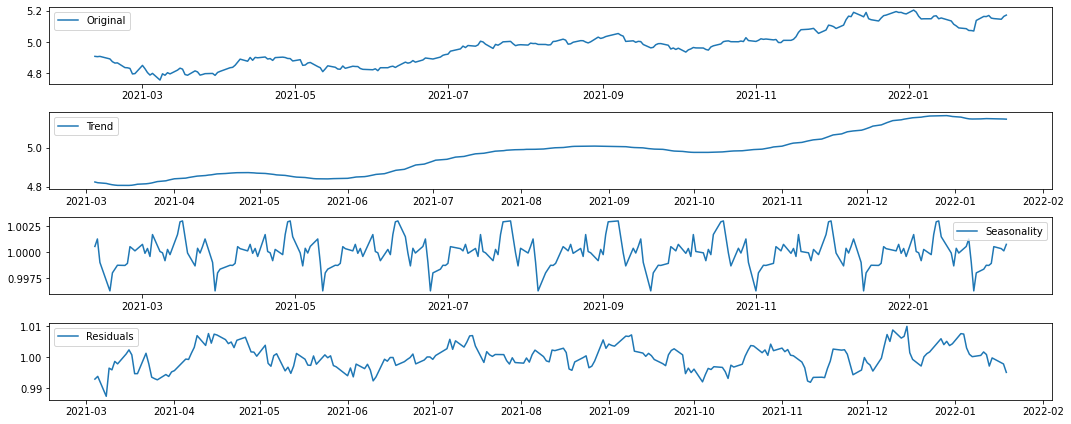

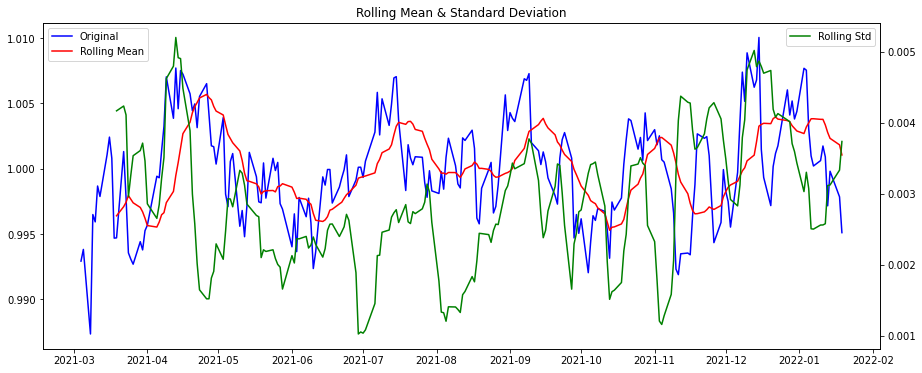

Results of Dickey-Fuller Test:
Test Statistic                  -4.747775
p-value                          0.000068
#Lags Used                       6.000000
Number of Observations Used    216.000000
Critical Value (1%)             -3.460992
Critical Value (5%)             -2.875016
Critical Value (10%)            -2.573952
dtype: float64


In [57]:
# STEP 3 : 시계열 안정성 분석

# 1) 정성적 그래프 분석: 구간 통계치(Rolling Statistics) 시각화
plot_rolling_statistics(ts_log, window=12)

# 2) 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 3) 시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend  # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal  # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid  # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (15,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# 4) Residual 안정성 확인
residual.dropna(inplace=True)
plot_rolling_statistics(residual)  # 정성적 그래프 분석
augmented_dickey_fuller_test(residual)  # 정량적 그래프 분석

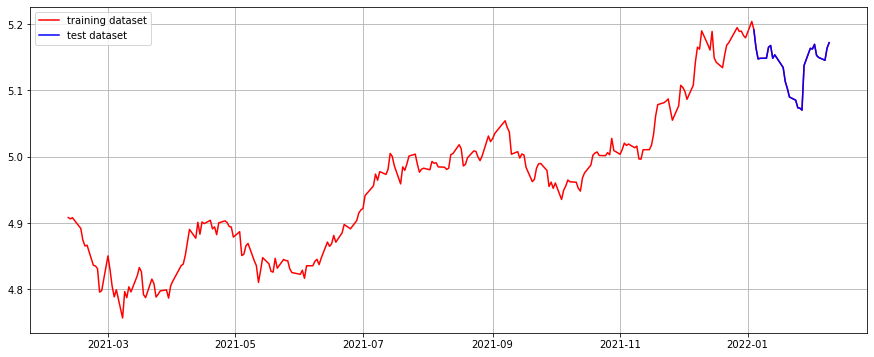

In [58]:
# STEP 4 : 학습, 테스트 데이터셋 생성

# 학습, 테스트 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(15,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

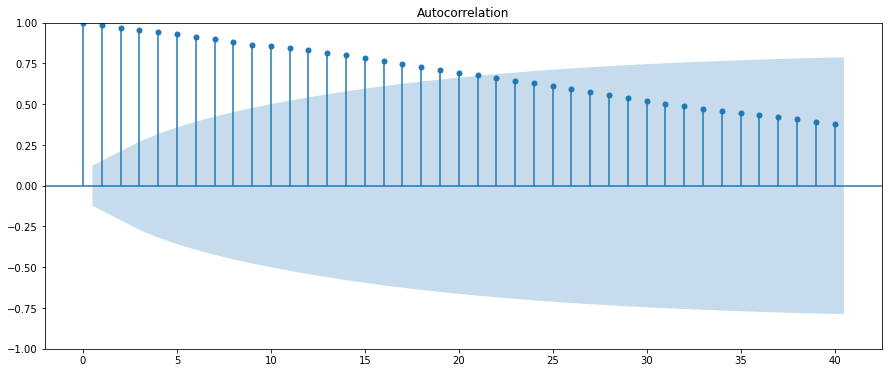

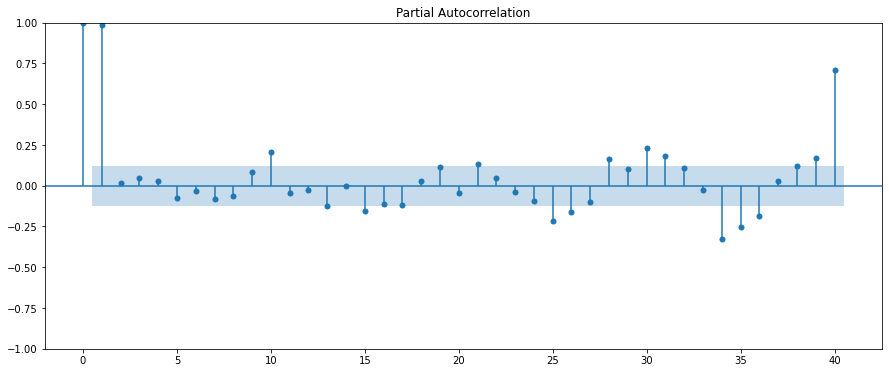

Results of Dickey-Fuller Test:
Test Statistic                -9.969701e+00
p-value                        2.257472e-17
#Lags Used                     2.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64


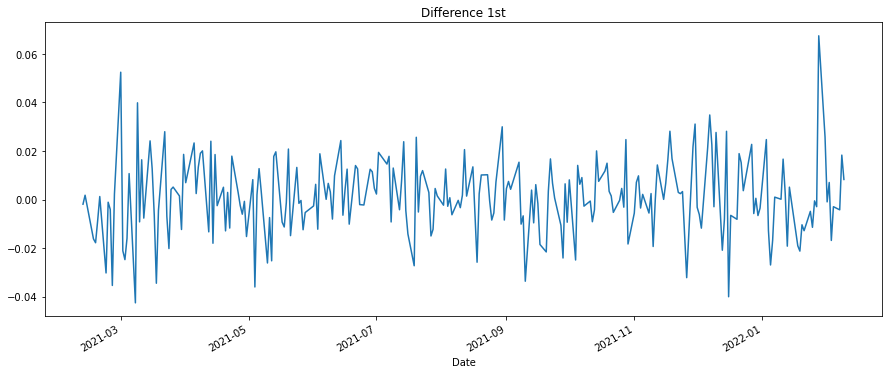

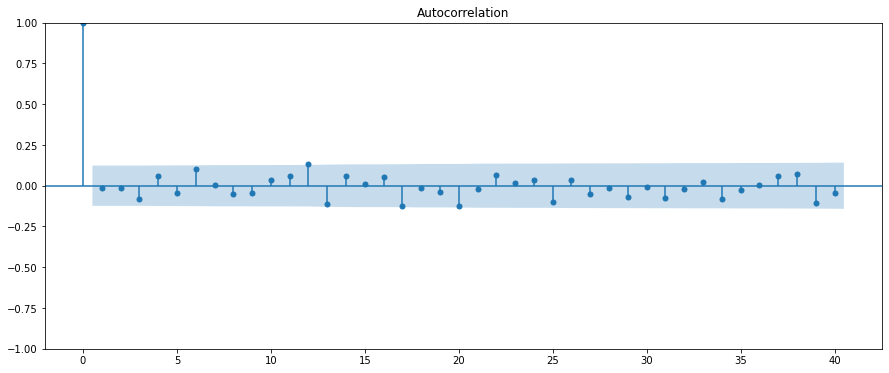

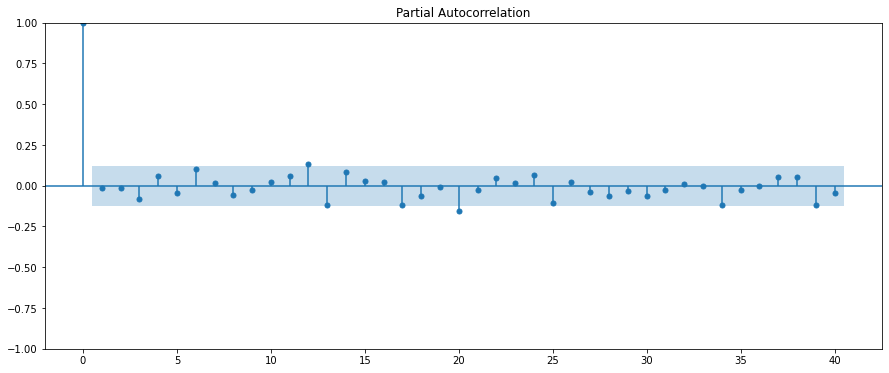

Results of Dickey-Fuller Test:
Test Statistic                -7.667778e+00
p-value                        1.623806e-11
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


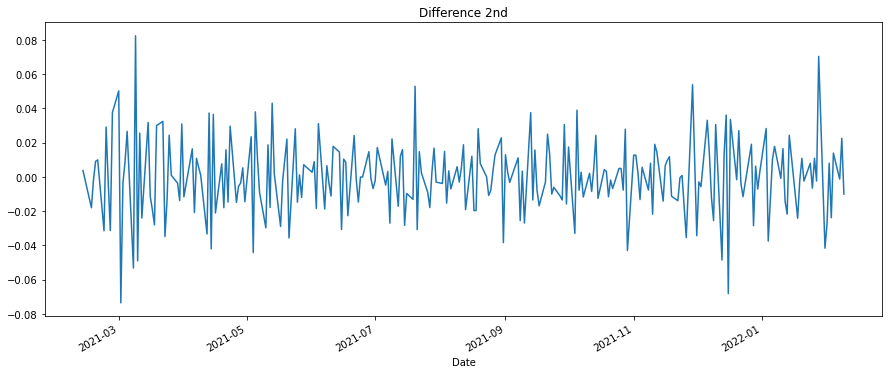

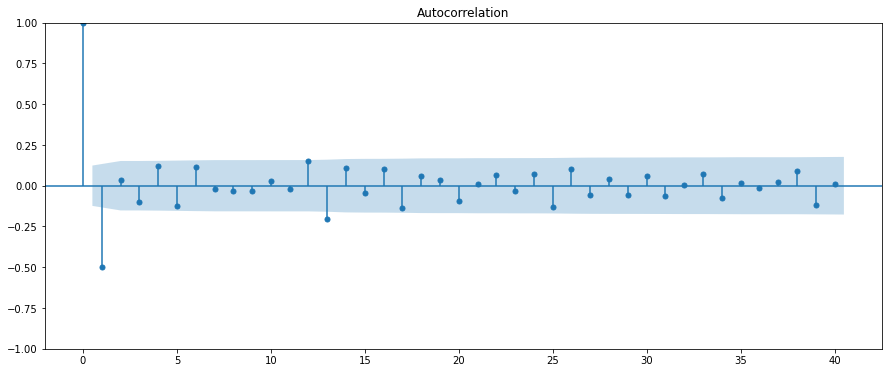

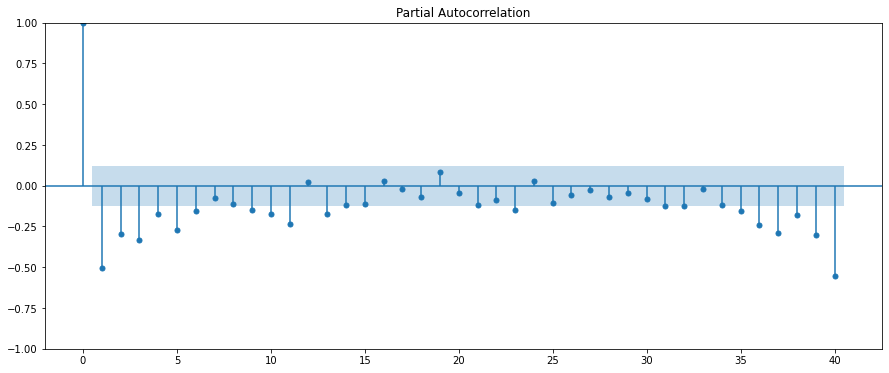

In [59]:
# STEP 5 : 적정 ARIMA 모수 찾기

# 1) ACF, PACF 그려보기 -> p,q 구하기
plot_acf(ts_log, lags=40)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log, lags=40)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

# 2) 차분 안정성 확인 -> d 구하기
# 2-1) 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 1차 차분 ACF, PACF 그려보기
plot_acf(diff_1, lags=40)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_1, lags=40)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

# 2-2) 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# 2차 차분 ACF, PACF 그려보기
plot_acf(diff_2, lags=40)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_2, lags=40)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- 실험할 ARIMA 모델 파라미터 결정

|p|d|q|
|:---:|:---:|:---:|
|1|0|1|
|1|0|2|
|1|0|3|
|1|1|1|
|1|1|2|
|1|1|3|
|1|2|1|

- p=1 고정
- d=0,1,2 사용
- d=2 일 때, q=1 고정
- q=1,2,3 로 실험

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 627.179
Date:                Fri, 18 Feb 2022   AIC                          -1246.357
Time:                        09:12:04   BIC                          -1232.657
Sample:                             0   HQIC                         -1240.829
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0158      0.128     39.118      0.000       4.764       5.267
ar.L1          0.9947      0.007    146.477      0.000       0.981       1.008
ma.L1         -0.0668      0.068     -0.979      0.3

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


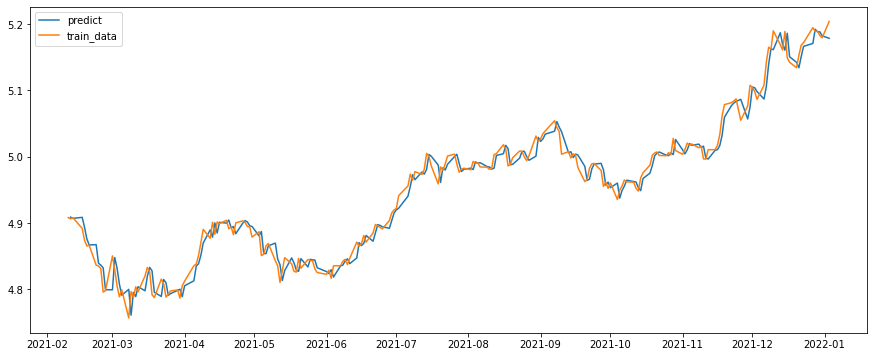

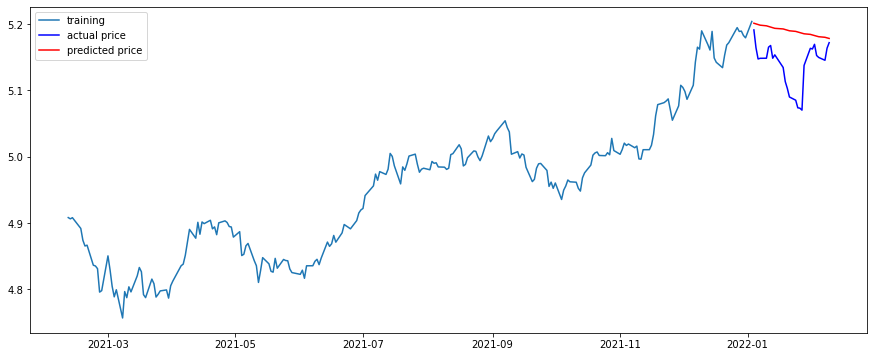

MSE:  111.81725545390802
MAE:  8.886246997312268
RMSE:  10.57436785126695
MAPE: 5.33%


In [60]:
# STEP 6 : ARIMA 모델 훈련과 테스트
show_result_of_ARIMA_model(1,0,1)

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 0, 2)   Log Likelihood                 627.232
Date:                Fri, 18 Feb 2022   AIC                          -1244.463
Time:                        09:12:05   BIC                          -1227.338
Sample:                             0   HQIC                         -1237.553
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0198      0.128     39.249      0.000       4.769       5.270
ar.L1          0.9950      0.007    146.052      0.000       0.982       1.008
ma.L1         -0.0676      0.069     -0.983      0.3

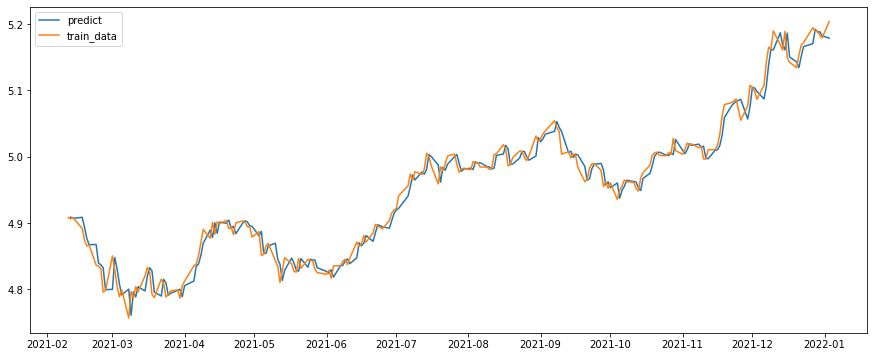

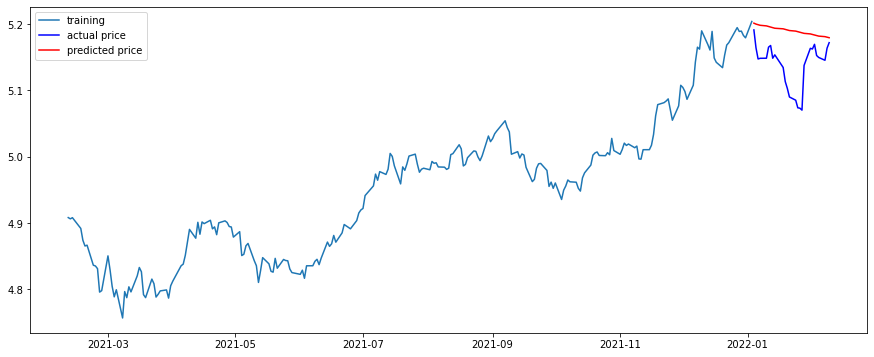

MSE:  112.96228583831315
MAE:  8.957930349937362
RMSE:  10.628371739749845
MAPE: 5.37%


In [61]:
# STEP 6 : ARIMA 모델 훈련과 테스트
show_result_of_ARIMA_model(1,0,2)

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 0, 3)   Log Likelihood                 627.515
Date:                Fri, 18 Feb 2022   AIC                          -1243.029
Time:                        09:12:06   BIC                          -1222.479
Sample:                             0   HQIC                         -1234.737
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0352      0.128     39.432      0.000       4.785       5.285
ar.L1          0.9955      0.007    148.911      0.000       0.982       1.009
ma.L1         -0.0507      0.067     -0.758      0.4

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


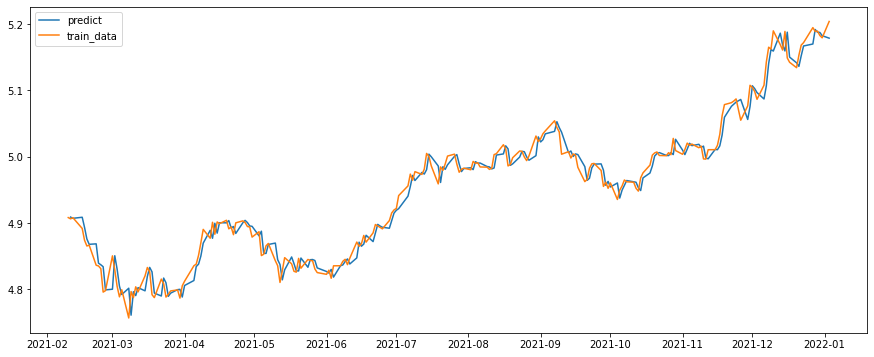

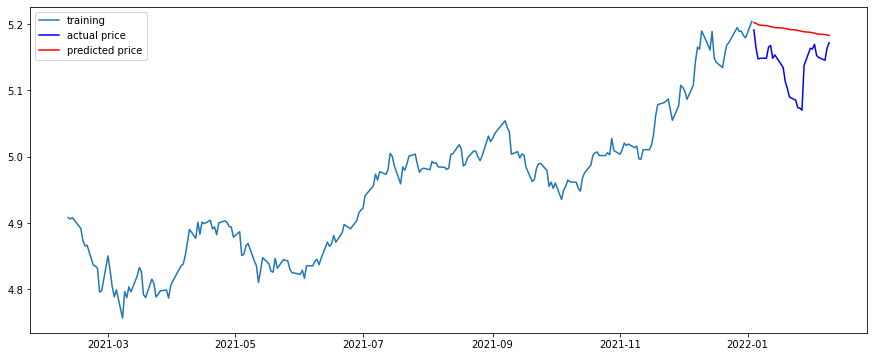

MSE:  118.24342292683082
MAE:  9.266161941767082
RMSE:  10.87397916711407
MAPE: 5.55%


In [62]:
# STEP 6 : ARIMA 모델 훈련과 테스트
show_result_of_ARIMA_model(1,0,3)

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 626.121
Date:                Fri, 18 Feb 2022   AIC                          -1246.243
Time:                        09:12:06   BIC                          -1235.981
Sample:                             0   HQIC                         -1242.101
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6330      0.767      0.826      0.409      -0.869       2.135
ma.L1         -0.6681      0.722     -0.925      0.355      -2.084       0.747
sigma2         0.0002   1.99e-05     11.538      0.0

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at 

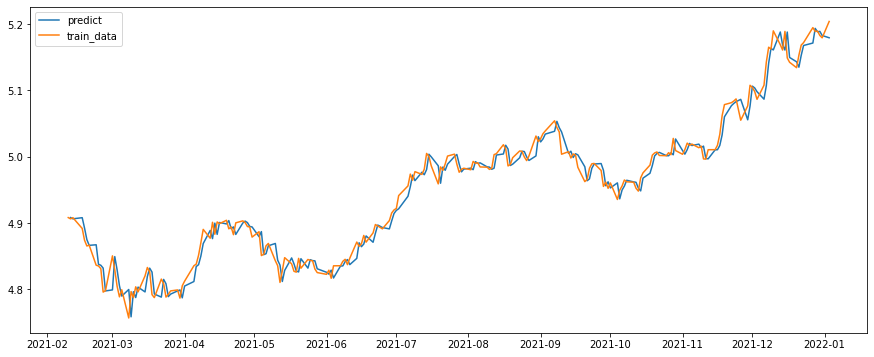

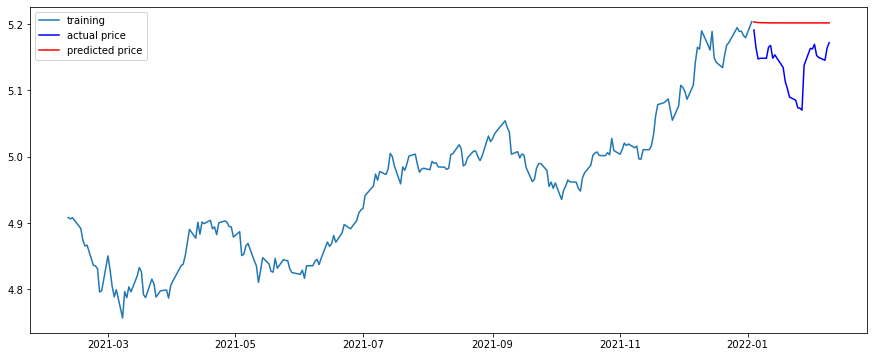

MSE:  155.98784164302577
MAE:  11.111842963239825
RMSE:  12.489509263498938
MAPE: 6.64%


In [63]:
# STEP 6 : ARIMA 모델 훈련과 테스트
show_result_of_ARIMA_model(1,1,1)

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at 

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 626.575
Date:                Fri, 18 Feb 2022   AIC                          -1245.149
Time:                        09:12:07   BIC                          -1231.467
Sample:                             0   HQIC                         -1239.628
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5692      1.118     -0.509      0.611      -2.761       1.622
ma.L1          0.5047      1.117      0.452      0.651      -1.684       2.693
ma.L2         -0.0041      0.118     -0.035      0.9

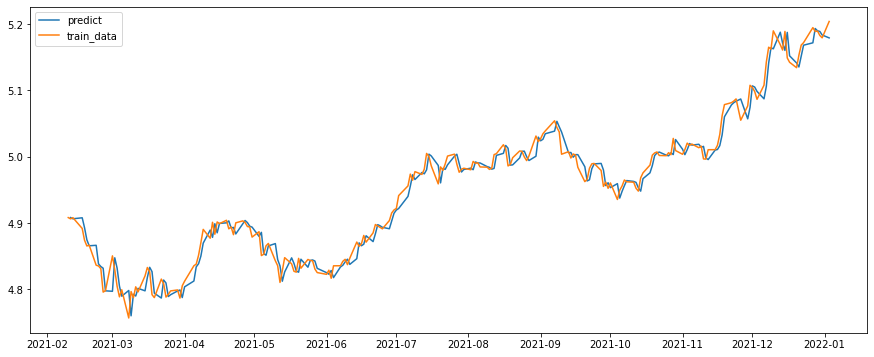

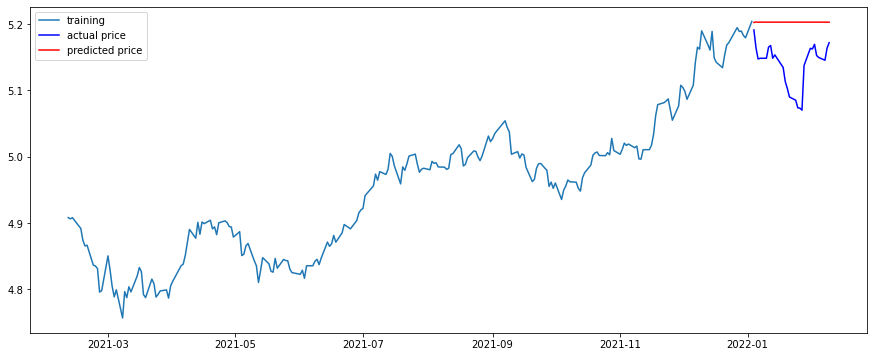

MSE:  160.30168563158384
MAE:  11.290403046715168
RMSE:  12.661030196298556
MAPE: 6.74%


In [64]:
# STEP 6 : ARIMA 모델 훈련과 테스트
show_result_of_ARIMA_model(1,1,2)

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 1, 3)   Log Likelihood                 628.929
Date:                Fri, 18 Feb 2022   AIC                          -1247.857
Time:                        09:12:08   BIC                          -1230.755
Sample:                             0   HQIC                         -1240.955
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9428      0.084    -11.203      0.000      -1.108      -0.778
ma.L1          0.9089      0.103      8.845      0.000       0.708       1.110
ma.L2         -0.0875      0.089     -0.983      0.3

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


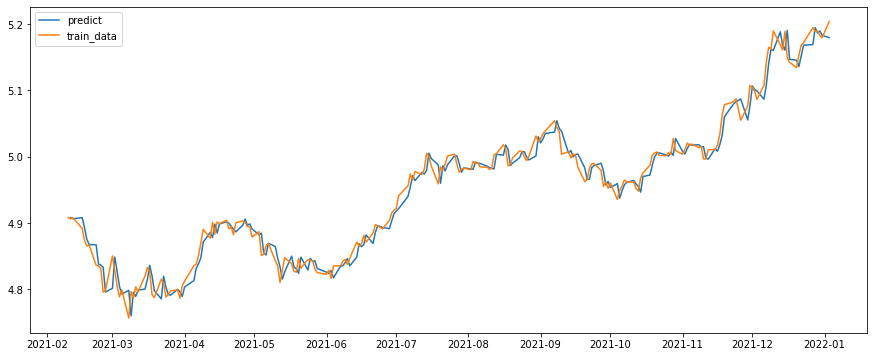

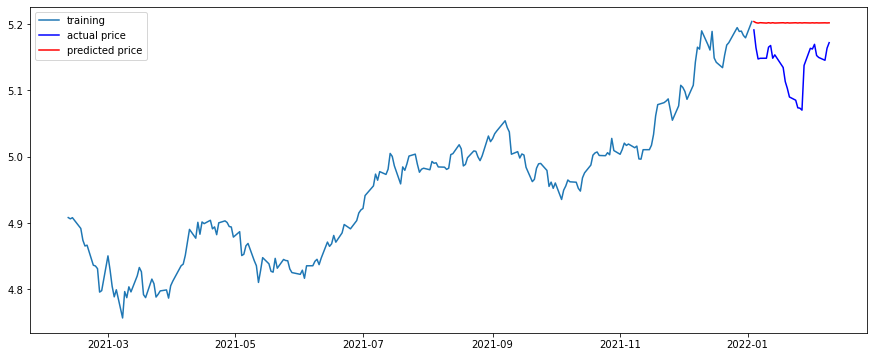

MSE:  155.87388098380808
MAE:  11.10703922411847
RMSE:  12.484946174646012
MAPE: 6.64%


In [65]:
# STEP 6 : ARIMA 모델 훈련과 테스트
show_result_of_ARIMA_model(1,1,3)

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 621.504
Date:                Fri, 18 Feb 2022   AIC                          -1237.009
Time:                        09:12:08   BIC                          -1226.760
Sample:                             0   HQIC                         -1232.872
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0786      0.066     -1.195      0.232      -0.207       0.050
ma.L1         -0.9825      0.020    -50.007      0.000      -1.021      -0.944
sigma2         0.0002   1.85e-05     12.450      0.0

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


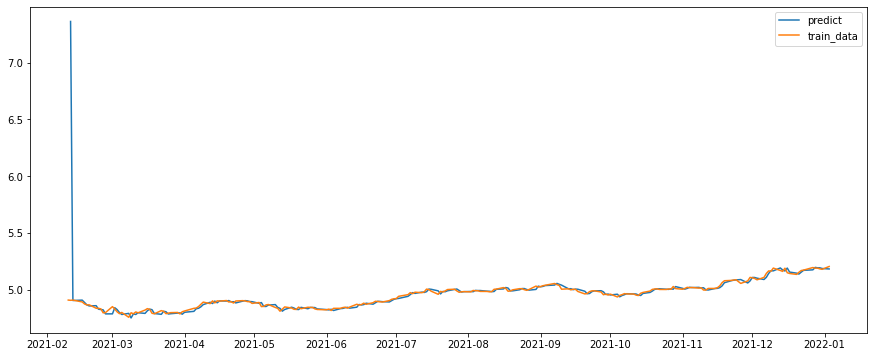

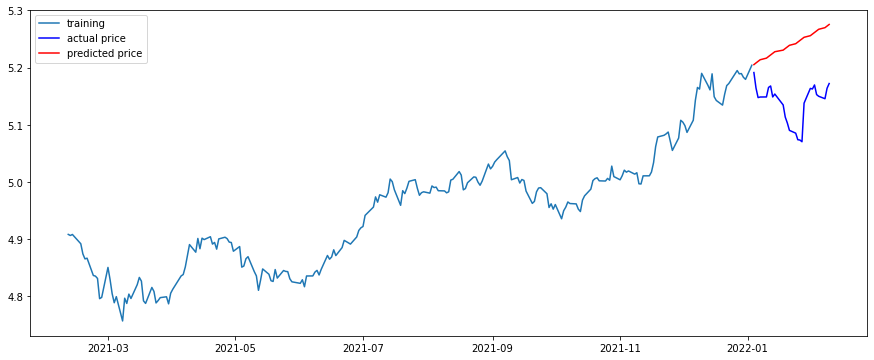

MSE:  385.237778590761
MAE:  18.246831120986695
RMSE:  19.627475094641213
MAPE: 10.84%


In [66]:
# STEP 6 : ARIMA 모델 훈련과 테스트
show_result_of_ARIMA_model(1,2,1)

- 애플 결과 정리

|p|d|q|MAPE|
|:---:|:---:|:---:|:---:|
|1|0|1|5.33%|
|1|0|2|5.37%|
|1|0|3|5.55%|
|1|1|1|6.64%|
|1|1|2|6.74%|
|1|1|3|6.64%|
|1|2|1|10.84%|

- p=1 고정
- d=0 의미는 no differencing
- MAPE 값이 낮을수록 성능이 좋다.

=> **ARIMA(1,0,1) 모델이 MAPE 5.33% 로 가장 성능이 좋다.**

---

### 종합 결과 정리

- 삼성 결과 정리
    - **ARIMA(1,0,1) 모델이 MAPE 1.04% 로 가장 성능이 좋다.**

|p|d|q|MAPE|
|:---:|:---:|:---:|:---:|
|1|0|1|1.04%|
|1|0|2|1.14%|
|1|0|3|1.17%|
|1|1|1|1.74%|
|1|1|2|1.73%|
|1|1|3|1.75%|
|1|2|1|4.60%|
|1|2|2|4.69%|
|1|2|3|4.67%|


- 구글 결과 정리
    - **ARIMA(1,0,1) 모델이 MAPE 4.71% 로 가장 성능이 좋다.**

|p|d|q|MAPE|
|:---:|:---:|:---:|:---:|
|1|0|1|4.71%|
|1|0|2|4.78%|
|1|0|3|5.45%|
|1|1|1|6.04%|
|1|1|2|6.04%|
|1|1|3|6.21%|
|1|2|1|7.72%|

- 아마존 결과 정리
    - **ARIMA(1,0,1) 모델이 MAPE 9.88% 로 가장 성능이 좋다.**

|p|d|q|MAPE|
|:---:|:---:|:---:|:---:|
|1|0|1|9.88%|
|1|0|2|9.90%|
|1|0|3|9.86%|
|1|1|1|10.83%|
|1|1|2|10.78%|
|1|1|3|10.60%|
|1|2|1|11.10%|

- 애플 결과 정리
    - **ARIMA(1,0,1) 모델이 MAPE 5.33% 로 가장 성능이 좋다.**

|p|d|q|MAPE|
|:---:|:---:|:---:|:---:|
|1|0|1|5.33%|
|1|0|2|5.37%|
|1|0|3|5.55%|
|1|1|1|6.64%|
|1|1|2|6.74%|
|1|1|3|6.64%|
|1|2|1|10.84%|

---

# 회고

### - 이번 프로젝트에서 **어려웠던 점**.
시계열(Time Series)과 ARIMA 모델이 통계학 내용들이라서 용어를 이해하는 것부터가 난관이었다.

### - 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- cf. 참고: 유튜브 ARIMA 설명 영상
    - [예측모델 재생목록](https://www.youtube.com/playlist?list=PLpIPLT0Pf7IqSuMx237SHRdLd5ZA4AQwd)
        - [ARIMA 모델 개요 - Part 1](https://youtu.be/ma_L2YRWMHI)
        - [ARIMA 모델 개요 - Part 2](https://youtu.be/P_3808Xv76Q)
    - [통계데이터분석 재생목록](https://www.youtube.com/playlist?list=PLY0OaF78qqGAxKX91WuRigHpwBU0C2SB_)
        - [ARIMA예측모델: 정상성과 자기상관](https://youtu.be/YQF5PDDI9jo?list=PLY0OaF78qqGAxKX91WuRigHpwBU0C2SB_)
        - [ARIMA예측모델: ARMA모델과 ARIMA모델](https://youtu.be/abOIK40QvDA?list=PLY0OaF78qqGAxKX91WuRigHpwBU0C2SB_)

1. 시계열 데이터(Time Series)
    - 시간의 흐름에 따라 얻어지는 데이터
    - 시간 단위
        - Daily (일)
        - Monthly (달)
        - Quarterly (분기)
        - Yearly (년)
    - 구성요소
        - Trend (추세변동)
        - Cycle (순환변동)
        - Seasonal variations (계절변동)
        - Random fluctuation (우연변동)
    - Stationary Process: 시간 관계없이 평균, 분산이 일정한 시계열 데이터
    - ACF, PACF 그래프를 보고 satationary 한지 확인할 수 있다.
        - ACF(Autocorrelation Function)
            - 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수
            - ACF plot에서 X 축은 상관 계수를 나타냄, y축은 시차 수를 나타냄
                - lag=0 은 자기 자신과의 correlation 이므로 항상 값은 1.0 이다. => lag=1 부터 확인해야 함!
            - 패턴 확인
                - 값이 천천히 떨어지는 패턴 => nonstationary
                - 값이 급격하게 떨어짐 or 패턴 없음 => stationary
            - ACF plot 에서 대부분의 residuals 값이 lag 40개 중에 2~3개만 boundary를 벗어날 경우 OK
        - PACF(Partial Autocorrelation Function)
            - 다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함수
2. ARIMA(Autoregressive Integrated Moving Average) Model
    - 모델 사용 과정
        - 데이터 전처리: stationary 로 변환하는 과정
        - 시범 사용 모델 찾기: ACF, PACF 그래프 패턴을 보고 결정
        - 파라미터 결정
        - 모델 진단 확인 - 별로면 다시 시범 모델 찾아야 함
        - 최종 모델 결정, 예측
    - ARIMA = AR(p) + I(d, Differencing 횟수) + MA(q) => (p,d,q)
        - p = order of the AR part of the model (자기회귀 모형(AR)의 시차)
        - d = order of the differencing (차분 누적(I) 횟수)
            - Differencing (차분)
                - Non-Stationary -> Stationary 로 변환
                - 보통 1차 차분까지면 충분하다. 최대 2차 차분까지 사용
                - 3차 차분이 필요한 데이터는 ARIMA 모델에 적합하지 않다.
        - q = order of the MA part of the model (이동평균 모형(MA)의 시차)
    - Model 참고
        - AR(Autoregressive)
            - Auto(=self) + regressive(회귀) => t 시점 데이터 y를 모델링함
            - 데이터가 stationary 해야 사용 가능
        - MA(Moving Average)
            - t 시점 데이터 y를 t 시점 에러와 과거의 에러들로 표현
            - 데이터가 stationary 해야 사용 가능
        - ARMA(Autoregressive and Moving Average)
            - ARMA = AR + MA
            - 데이터가 stationary 해야 사용 가능
3. ACF, PACF 그래프를 보고 ARIMA 모델 모수(p,q) 결정 방법
    - d 는 이미 1 또는 2로 결정됨. 3차 차분은 ARIMA 모델에 적합하지 않기 때문!
    - 사실상 p,d,q 경우의 수를 모두 돌려서 최적의 조합을 찾으면 된다.

| Model | ACF | Partial ACF |
| :---: | :---: | :---: |
| MA(q) | Cut off after lag q (q 시차 이후 0으로 절단) | Die out (지수적으로 감소, 소멸하는 sine 함수 형태) |
| AR(p) | Die out (지수적으로 감소, 소멸하는 sine 함수 형태) | Cut off after lag p (p 시차 이후 0으로 절단) |
| ARMA(p, q) | Die out (시차 (q-p) 이후부터 소멸) | Die out (시차 (q-p) 이후부터 소멸) |

4. 모델 신뢰성 검증
    - 오차 평균의 크기가 크게 차이나는 모델을 비교하는 경우, 오차 평균의 크기가 더 작은 모델을 더 좋은 모델로 평가
    - [지표 종류](https://mizykk.tistory.com/102)
        - cf. Error = 오차 = 실제값 - 예측값
        - MSE(Mean Squared Error)
            - 회귀 분석에서 사용하는 성능 지표
            - MSE = mean((실제값-예측값)**2)
        - MSLE(Mean Squared Log Error)
            - MSLE = log(MSE)
        - MAE(Mean Absolute Error)
            - MAE = mean(abs(예측값 - 실제값))
            - outlier 에 취약함
        - RMSE(Root MSE)
            - RMSE = sqrt(MSE)
        - MAPE(Mean Absolute Percentage Error)
            - 회귀 분석에서 사용하는 성능 지표
            - 오차가 예측값에서 차지하는 정도를 나타내는 지표
            - MAE 를 퍼센트로 변환 => outlier 에 취약함
            - MAPE = (예측값 - 실제값)/예측값 = 오차/예측값
            - 0 에 가까울수록 회귀 모형의 성능이 좋다고 해석
        - MPE(Mean Percentage Error)
            - MPE = MAPE 에서 절대값을 제외한 지표 => outlier 에 취약함
5.  Seasonal ARIMA 모델
    - 기존 ARIMA (p,d,q) 모형  + 계절 변동 반영(=계절성 주기를 나타내는 차수 s 추가)
    - 각 계절에 따른 독립적인 ARIMA 모델이 합쳐져 있는 모형
    - ARIMA (p,d,q)(P,D,Q)s 로 표기
        - (p,d,q): 비계절 요인
        - (P,D,Q)s: 계절 요인
        - 결정해야 할 파라미터 개수: 7개(p,d,q,P,D,Q,s)
    - e.g. 월별 계절성 나타낼 때(1~12월): s=12
    - e.g. 분기별 계절성 나타낼 때(봄, 여름, 가을, 겨울): s=4
    - 줄여서 SARIMA 모델이라고 표현


### - 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.

>#### **루브릭**
>|번호|평가문항|상세기준|
>|:---:|---|---|
>|1|시계열의 안정성이 충분히 확인되었는가?|플로팅과 adfuller 메소드가 모두 적절히 사용되었음|
>|2|ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?|p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨|
>|3|예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?|3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨|

시계열(Time Series) 데이터의 안정성(Stationary)을 확인하기 위해 statsmodels 패키지에서 제공하는 플로팅 기능(plot_acf(), plot_pacf())과 ADF Test를 수행하는 adfuller() 메소드를 사용해보았다.

ARIMA 모델의 모수는 (p,d,q) 이다. ACF, PACF 를 보면서 p, q 값을 선택하고 차분(Differencing)을 적용한 뒤 ACF, PACF 를 살펴보았다. 대부분 1차 차분까지, 최대 2차 차분이면 충분하다는 내용을 유튜브에서 봤기 때문에 3차 차분은 진행하지 않았다. 3차 차분이 필요한 데이터는 ARIMA 모델에 적합하지 않다고 한다.

여러 모수 값들로 ARIMA 모델을 실험해 본 결과, 모두 MAPE 값이 15% 미만이었고 그중에서 p=1, d=0, q=1 일 때 가장 값이 제일 작았다. 따라서 ARIMA(1,0,1) 모델의 성능이 제일 좋았다.


### - 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
없음

### - **자기 다짐**
통계학 내용도 알아야 할 것이 널렸다. 시간이 날 지 모르겠지만 다시 한번 차근차근 시계열 내용을 복습해야 될 것 같다.